### Misclassified Image SSIM Analysis

This notebook analyzes misclassified images and compares image similarities using SSIM to determine whether CIFAR10.1 misclassified images are less si than misclassified images in CIFAR10 test set. 


##### Import Libraries and Modules

In [1]:
!pip install upsetplot

You are using pip version 10.0.1, however version 20.2b1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [78]:
from skimage.measure import compare_ssim as ssim
from ast import literal_eval
import os
import pandas as pd
from glob import glob
import numpy as np
from sklearn.metrics import classification_report
import torchvision
from PIL import Image
from mpl_toolkits.axes_grid1 import ImageGrid
import seaborn as sns
import matplotlib.pyplot as plt
from upsetplot import plot 
from matplotlib import pyplot
%matplotlib inline

## determine misclassified images by category

In [3]:
#collect data and labels for cifar 10 and 10.1
testset = torchvision.datasets.CIFAR10(root='../../data/cifar10/', train=False,
                                       download=True)
test_labels_CIFAR10 = testset.targets
test_data_CIFAR10 = testset.data

# Retrieve the official labels of the CIFAR10.1 test dataset
test_labels_CIFAR101 =np.load('../data/cifar101/cifar10.1_v6_labels.npy')  
test_data_CIFAR101 = np.load('../data/cifar101/cifar10.1_v6_data.npy')

# Create a dictionary that maps numeric class number to class name
class_dict = {0: "airplane",
              1: "automobile",
              2: "bird",
              3: "cat",
              4: "deer",
              5: "dog",
              6: "frog",
              7: "horse",
              8: "ship",
              9: "truck"
}

classes = ['0 airplane', '1 automobile', '2 bird', '3 cat', '4  deer', '5 dog', '6 frog', 
           '7 horse', '8 ship', '9 truck']

# Confirm that when we compare these labels to our guesses, we get the accuracy score.
def confirm_score(zfile, test_labels):
    print("\nAccuracy:", zfile['acc'])
    print(" -> Sanity Check:", np.sum(test_labels_CIFAR10 == zfile['labels']), "of", 
          len(test_labels), "correct\n")
    
    # Examine the classes to see if the model is balanced in its accuracy across all labels 
    report = classification_report(test_labels, zfile['labels'], target_names=classes, output_dict=True)
    print(pd.DataFrame(report).transpose())


Files already downloaded and verified


In [123]:
number_to_analyze = 100

def error_by_r_score(zfile, test_labels, testset):
    images_to_print = []
    
    # Determine the probability we associatd with our predicted label
    pp_max = np.max(zfile['probs'], axis=1)

    # Retrieve the model's predicted probability of the correct label
    pp_correct = zfile['probs'][range(zfile['probs'].shape[0]), test_labels]

    # Calculate the R ratio for each document
    r = pp_max/pp_correct

    # Retrieve the row numbers where the R score is the highest
    max_r_value_indexes = r.argsort()[-1 * number_to_analyze:]

    # Create list to hold stats on highest R Score images
    stats = []
    
    for mi in max_r_value_indexes:
        #print("-- R Ratio:", r[mi], " ( index", mi, 
        #      ")\n   Guessed Label:", zfile['labels'][mi], class_dict[zfile['labels'][mi]], 
        #      "\n   Correct Label:", test_labels[mi], class_dict[test_labels[mi]],
        #      "\n   Class Probs:", zfile['probs'][mi], "\n")
        
        img_dict = {'prob_predicted': pp_max[mi],
                    'prob_correct': pp_correct[mi],
                    'r_value': r[mi],
                    'label_predicted_id': zfile['labels'][mi],
                    'label_predicted': class_dict[zfile['labels'][mi]],
                    'correct_label': test_labels[mi],
                    'correct_label_id': class_dict[test_labels[mi]],
                    'img_index': mi
                   }

        img=Image.fromarray(testset[mi])
        images_to_print.append(img)
        stats.append(img_dict)
        
    # Print the misclassified images
    fig = plt.figure(figsize=(16, 4))
    grid = ImageGrid(fig, 111,  
                     nrows_ncols=(2, 10),  
                     axes_pad=0.1,  
                     )

    for ax, im in zip(grid, images_to_print):
        # Iterating over the grid returns the Axes.
        ax.imshow(im)
        
    return pd.DataFrame(stats)

In [12]:
def mse(image1, image2):
    error = np.sum((image1.astype("float") - image2.astype("float")) ** 2)
    error /= float(image1.shape[0] * image1.shape[1])
    return error

def compare_images(image1, image2):
    # mean square error between each pixel for the two images, higher the MSE mean less similar
    m = mse(image1, image2)
    # similarities within pixels, score of one is very similar and lower means less similar
    s = ssim(image1, image2, multichannel=True)
    #fig = plt.figure(title)
    #print("MSE:  %.2f SSIM: %.2f" % (m,s))
    return m, s

In [10]:
# calculate SSIM and MSE for most misclassified images as compared to cifar10 and 10.1

def calc_SSIM_MSE(model_error_df):
    comparison_stats = []
    for im in model_error_df['img_index']:
        for i in range(0,2000):
            mse_ssim_cifar10 = compare_images(test_data_CIFAR10[i], test_data_CIFAR10[im])
            #print("CIFAR10:   MSE:  %.2f SSIM: %.3f" % mse_ssim_cifar10)
            mse_ssim_cifar101 = compare_images(test_data_CIFAR101[i], test_data_CIFAR10[im]) 
            #print("CIFAR10.1: MSE:  %.2f SSIM: %.3f" % mse_ssim)
            #print('\n')

            stats_dict = {'CIFAR10_MSE': mse_ssim_cifar10[0], 'CIFAR10_SSIM': mse_ssim_cifar10[1],
                          'CIFAR101_MSE': mse_ssim_cifar101[0], 'CIFAR101_SSIM': mse_ssim_cifar101[1]}
            comparison_stats.append(stats_dict)
    return pd.DataFrame(comparison_stats)

In [91]:
# calculate SSIM and MSE for most misclassified images as compared to cifar10 and 10.1

def calc_SSIM_MSE(model_error_df, zfile):
    comparison_stats = []
    for im in model_error_df['img_index']:
        for i in range(0,2000):
            mse_ssim_cifar10 = compare_images(test_data_CIFAR10[i], test_data_CIFAR10[im])
            #print("CIFAR10:   MSE:  %.2f SSIM: %.3f" % mse_ssim_cifar10)
            mse_ssim_cifar101 = compare_images(test_data_CIFAR101[i], test_data_CIFAR10[im]) 
            #print("CIFAR10.1: MSE:  %.2f SSIM: %.3f" % mse_ssim)
            #print('\n')

            stats_dict = {'label_predicted_id': zfile['labels'][im], 
                          'label_predicted': class_dict[zfile['labels'][im]],
#                           'correct_label': test_labels[im],
#                           'correct_label_id': class_dict[test_labels[im]],
                          'img_index': im, 
                          'CIFAR10_MSE': mse_ssim_cifar10[0], 'CIFAR10_SSIM': mse_ssim_cifar10[1],
                          'CIFAR101_MSE': mse_ssim_cifar101[0], 'CIFAR101_SSIM': mse_ssim_cifar101[1]}
            comparison_stats.append(stats_dict)
    return pd.DataFrame(comparison_stats)

In [132]:
def plot_SSIM_MSE(metrics_df, model):

    x1 = metrics_df['CIFAR10_SSIM']
    x2 = metrics_df['CIFAR101_SSIM']
    
    #plt1 = met_resnet32_no_ra['CIFAR10_SSIM'].plot.hist(bins=12, alpha=0.5, title='Resnet32 Misclassified CIFAR10 Images', legend=1)
    #plt2 = met_resnet32_no_ra['CIFAR101_SSIM'].plot.hist(bins=12, alpha=0.5, title='Resnet32 Misclassified CIFAR10 Images', legend=1)
    
    ax1 = sns.distplot(x1, hist = True, kde = False, bins = 10, label = "Misclassified CIFAR10 Images")
    ax2 = sns.distplot(x2, hist = True, kde = False, bins = 10, label = "Misclassified CIFAR10.1 Images")
    
    plt.title("SSIM for " + model + " Misclassified Images" )
    plt.ylabel("Number of Observations")
    plt.xlabel("SSIM")
    plt.legend()
#     plt.ylim(0, 1000)
    plt.show()
    
    print("CIFAR10 SSIM Mean:     ", np.mean(x1))
    print("CIFAR10.1 SSIM Mean:   ", np.mean(x2))
    print("CIFAR10 SSIM Median:   ", np.median(x1))
    print("CIFAR10.1 SSIM Median: ", np.median(x2))

In [130]:
def plot_SSIM_MSE_by_label(metrics_df, model):

    #x1 = metrics_df['CIFAR10_SSIM']
    #x2 = metrics_df['CIFAR101_SSIM']
    for label in range(9):
        x0_1 = metrics_df[metrics_df['label_predicted_id'] == label]['CIFAR10_SSIM']
        x0_2 = metrics_df[metrics_df['label_predicted_id'] == label]['CIFAR101_SSIM']

        #plt1 = met_resnet32_no_ra['CIFAR10_SSIM'].plot.hist(bins=12, alpha=0.5, title='Resnet32 Misclassified CIFAR10 Images', legend=1)
        #plt2 = met_resnet32_no_ra['CIFAR101_SSIM'].plot.hist(bins=12, alpha=0.5, title='Resnet32 Misclassified CIFAR10 Images', legend=1)

        ax0_1 = sns.distplot(x0_1, hist = True, kde = False, bins = 10, label = "Misclassified CIFAR10 Images")
        ax0_2 = sns.distplot(x0_2, hist = True, kde = False, bins = 10, label = "Misclassified CIFAR10.1 Images")
        
        label_predicted = class_dict[label]

        plt.title("SSIM for " + model + " Misclassified Images for " + label_predicted)
        plt.ylabel("Number of Observations")
        plt.xlabel("SSIM")
        plt.legend()
    #     plt.ylim(0, 1000)
        plt.show()
        
        print("CIFAR10 SSIM Mean:     ", np.mean(x0_1))
        print("CIFAR10.1 SSIM Mean:   ", np.mean(x0_2))
        print("CIFAR10 SSIM Median:   ", np.median(x0_1))
        print("CIFAR10.1 SSIM Median: ", np.median(x0_2))

### resnet 32, no ra

/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/skimage/util/arraycrop.py:177: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  cropped = ar[slices]


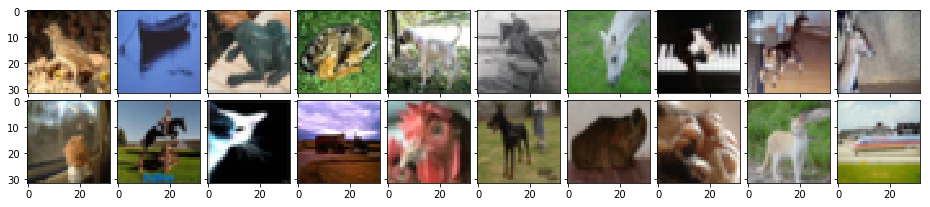

In [124]:
output = './resnet_basic_32/predictions_160.npz'
npzfile = np.load(output)
#confirm_score(npzfile, test_labels_CIFAR10)
df_resnet32_errors = error_by_r_score(npzfile, test_labels_CIFAR10, test_data_CIFAR10)
met_resnet32_no_ra = calc_SSIM_MSE(df_resnet32_errors, npzfile)


/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


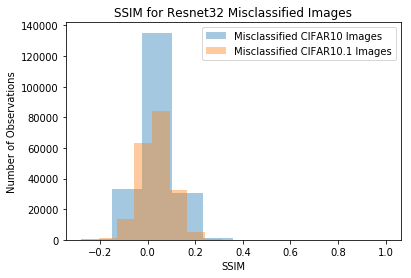

CIFAR10 SSIM Mean:      0.039274729643062944
CIFAR10.1 SSIM Mean:    0.037251401514988854
CIFAR10 SSIM Median:    0.03791545215309293
CIFAR10.1 SSIM Median:  0.03582177874566785


In [133]:
plot_SSIM_MSE(met_resnet32_no_ra, "Resnet32")

/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


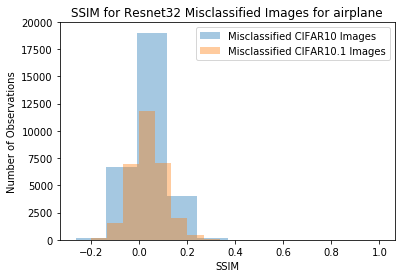

CIFAR10 SSIM Mean:  0.04114757476286092
CIFAR10.1 SSIM Mean:  0.03849151938301687
CIFAR10 SSIM Median:  0.038579678731556814
CIFAR10.1 SSIM Median:  0.035786017945229176


/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


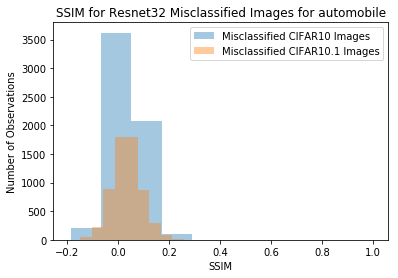

CIFAR10 SSIM Mean:  0.03561971197705619
CIFAR10.1 SSIM Mean:  0.033751351559787535
CIFAR10 SSIM Median:  0.03404929179394941
CIFAR10.1 SSIM Median:  0.03258584499170557


/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


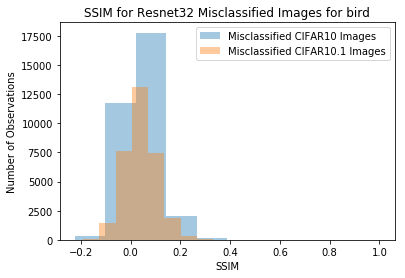

CIFAR10 SSIM Mean:  0.0435521045091082
CIFAR10.1 SSIM Mean:  0.04104980733453079
CIFAR10 SSIM Median:  0.040780009097413805
CIFAR10.1 SSIM Median:  0.03857329048189516


/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


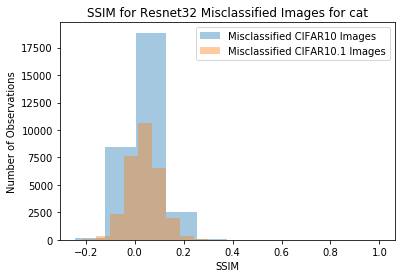

CIFAR10 SSIM Mean:  0.04066452971708386
CIFAR10.1 SSIM Mean:  0.03871527342279211
CIFAR10 SSIM Median:  0.039868891937128295
CIFAR10.1 SSIM Median:  0.03772670606927414


/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


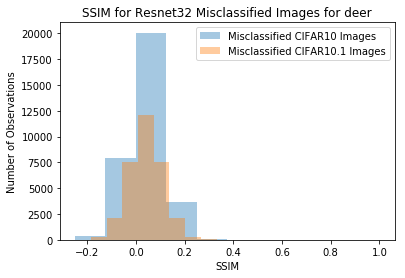

CIFAR10 SSIM Mean:  0.04260342446764204
CIFAR10.1 SSIM Mean:  0.040325033577230565
CIFAR10 SSIM Median:  0.04240580329771798
CIFAR10.1 SSIM Median:  0.04002069444910357


/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


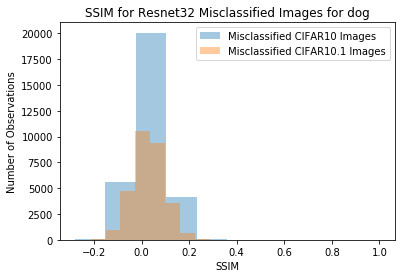

CIFAR10 SSIM Mean:  0.033586606425729124
CIFAR10.1 SSIM Mean:  0.031362989076105845
CIFAR10 SSIM Median:  0.03290426173381593
CIFAR10.1 SSIM Median:  0.030448281239938528


/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


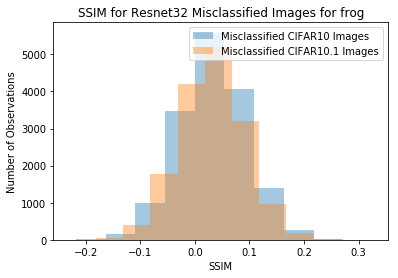

CIFAR10 SSIM Mean:  0.03305976111913264
CIFAR10.1 SSIM Mean:  0.03262700012474683
CIFAR10 SSIM Median:  0.03243484788436557
CIFAR10.1 SSIM Median:  0.0320018575139685


/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


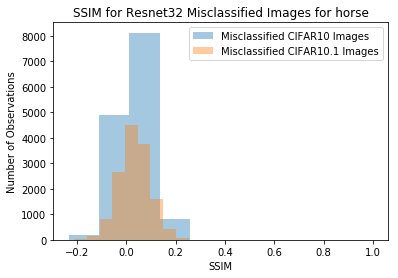

CIFAR10 SSIM Mean:  0.035336480499802876
CIFAR10.1 SSIM Mean:  0.034688164946183854
CIFAR10 SSIM Median:  0.03502428057168713
CIFAR10.1 SSIM Median:  0.03362895432488784


/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


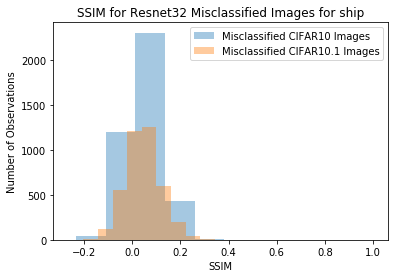

CIFAR10 SSIM Mean:  0.04863789513708591
CIFAR10.1 SSIM Mean:  0.04483715303484462
CIFAR10 SSIM Median:  0.045712462460819225
CIFAR10.1 SSIM Median:  0.043387760233275244


In [128]:
plot_SSIM_MSE_by_label(met_resnet32_no_ra, "Resnet32")

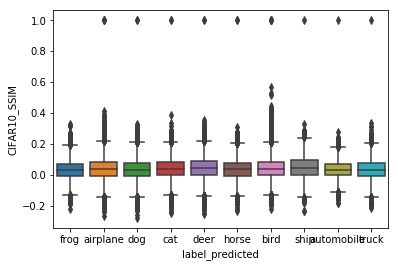

In [134]:
sns.boxplot(x="label_predicted", y="CIFAR10_SSIM", data=met_resnet32_no_ra);

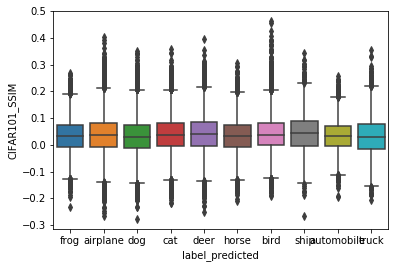

In [135]:
sns.boxplot(x="label_predicted", y="CIFAR101_SSIM", data=met_resnet32_no_ra);

/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/skimage/util/arraycrop.py:177: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  cropped = ar[slices]


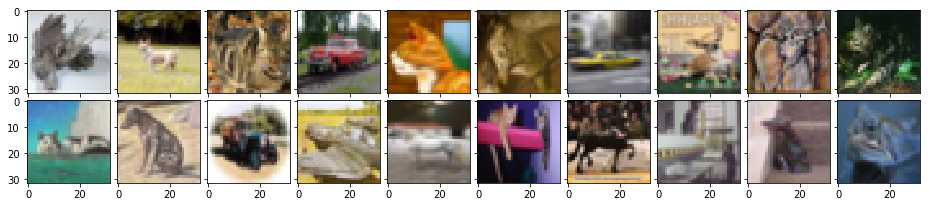

In [138]:
output = './resnet_basic_32/predictions_160_CIFAR101.npz'
npzfile101 = np.load(output)
#confirm_score(npzfile101, test_labels_CIFAR101)
df_resnet32_errors_101  = error_by_r_score(npzfile101, test_labels_CIFAR101, test_data_CIFAR101)
met_resnet32_no_ra_101 = calc_SSIM_MSE(df_resnet32_errors_101, npzfile101)

/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


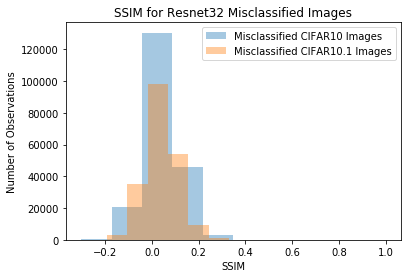

CIFAR10 SSIM Mean:      0.04443927563625329
CIFAR10.1 SSIM Mean:    0.041597020935281295
CIFAR10 SSIM Median:    0.04125890505670046
CIFAR10.1 SSIM Median:  0.03915137455757549


In [139]:
plot_SSIM_MSE(met_resnet32_no_ra_101, "Resnet32")

/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


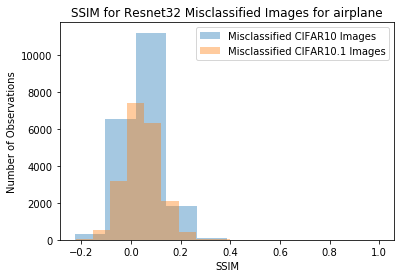

CIFAR10 SSIM Mean:      0.048966154039805115
CIFAR10.1 SSIM Mean:    0.046089798705715286
CIFAR10 SSIM Median:    0.046709002055075236
CIFAR10.1 SSIM Median:  0.04490164206341221


/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


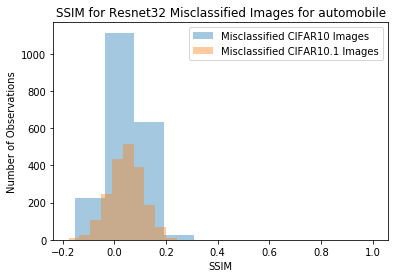

CIFAR10 SSIM Mean:      0.04723922591657119
CIFAR10.1 SSIM Mean:    0.045343578488032846
CIFAR10 SSIM Median:    0.04814194472481641
CIFAR10.1 SSIM Median:  0.04677819553154908


/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


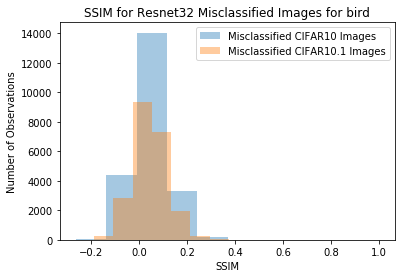

CIFAR10 SSIM Mean:      0.04832494872103822
CIFAR10.1 SSIM Mean:    0.04454131659736717
CIFAR10 SSIM Median:    0.04485950775684229
CIFAR10.1 SSIM Median:  0.04120723026351783


/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


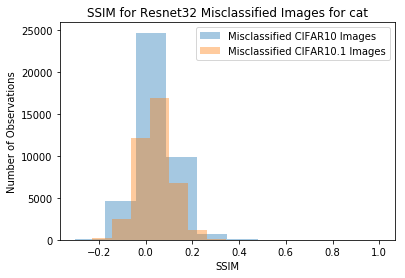

CIFAR10 SSIM Mean:      0.04544436834659901
CIFAR10.1 SSIM Mean:    0.042829696842552334
CIFAR10 SSIM Median:    0.04260620817728619
CIFAR10.1 SSIM Median:  0.0407810911744845


/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


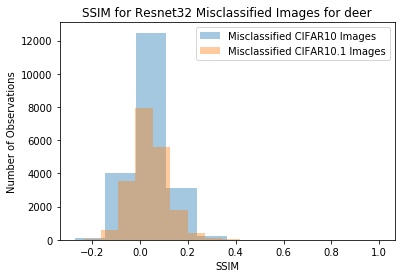

CIFAR10 SSIM Mean:      0.04236988076385368
CIFAR10.1 SSIM Mean:    0.039131987449558904
CIFAR10 SSIM Median:    0.03762810046981961
CIFAR10.1 SSIM Median:  0.03556931489872349


/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


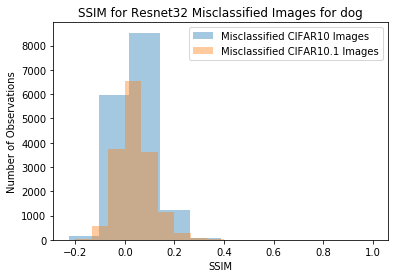

CIFAR10 SSIM Mean:      0.043697008569363885
CIFAR10.1 SSIM Mean:    0.042203342698239624
CIFAR10 SSIM Median:    0.03752409746361803
CIFAR10.1 SSIM Median:  0.03591444089514757


/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


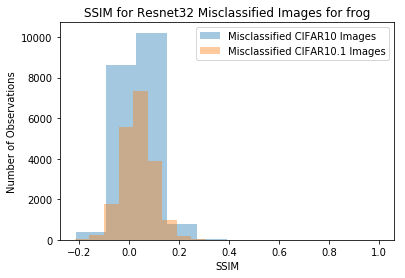

CIFAR10 SSIM Mean:      0.03650925931513293
CIFAR10.1 SSIM Mean:    0.03408676656760505
CIFAR10 SSIM Median:    0.0351714067138052
CIFAR10.1 SSIM Median:  0.03314493047138751


/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


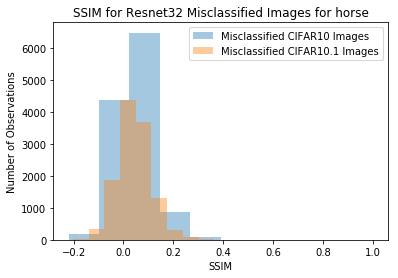

CIFAR10 SSIM Mean:      0.04695689288836862
CIFAR10.1 SSIM Mean:    0.04377241327836104
CIFAR10 SSIM Median:    0.04290191527176247
CIFAR10.1 SSIM Median:  0.04118408234765209


/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


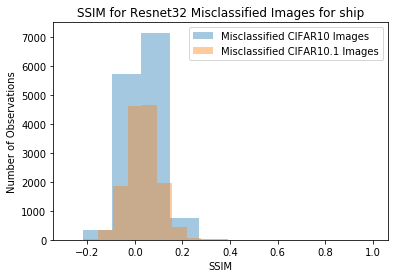

CIFAR10 SSIM Mean:      0.03767286089432636
CIFAR10.1 SSIM Mean:    0.03495710308763188
CIFAR10 SSIM Median:    0.036229814424654457
CIFAR10.1 SSIM Median:  0.03384824227156309


In [140]:
plot_SSIM_MSE_by_label(met_resnet32_no_ra_101, "Resnet32")

### resnet 32 w/ ra 25

/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/skimage/util/arraycrop.py:177: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  cropped = ar[slices]


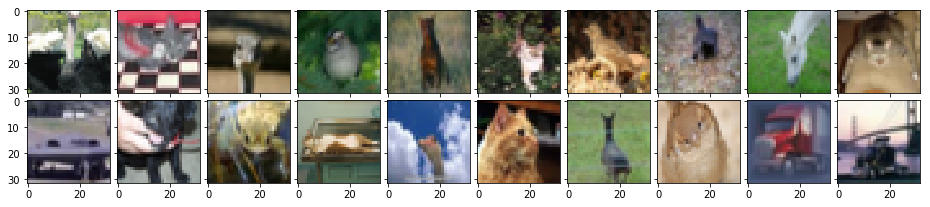

In [141]:
output = './resnet_basic_32_ra_2_5/predictions_400_refined50.npz'
npzfile = np.load(output)
#confirm_score(npzfile, test_labels_CIFAR10)
df_resnet32_errors_ra_2_5 = error_by_r_score(npzfile, test_labels_CIFAR10, test_data_CIFAR10)
met_resnet32_ra_2_5 = calc_SSIM_MSE(df_resnet32_errors_ra_2_5, npzfile)

/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


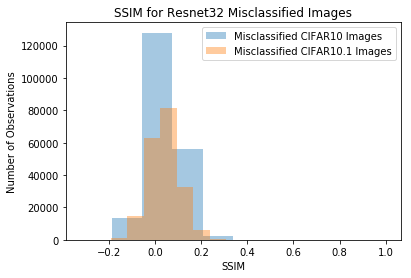

CIFAR10 SSIM Mean:      0.04005968358144538
CIFAR10.1 SSIM Mean:    0.03826244436717395
CIFAR10 SSIM Median:    0.038443702108657316
CIFAR10.1 SSIM Median:  0.03683750542570306


In [142]:
plot_SSIM_MSE(met_resnet32_ra_2_5, "Resnet32")

/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


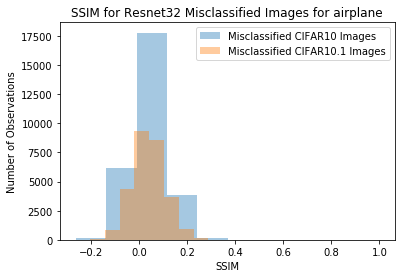

CIFAR10 SSIM Mean:      0.04140212551273351
CIFAR10.1 SSIM Mean:    0.039197626092705384
CIFAR10 SSIM Median:    0.03960897400144146
CIFAR10.1 SSIM Median:  0.037403662578277104


/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


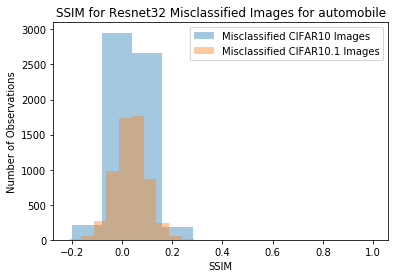

CIFAR10 SSIM Mean:      0.03886934128790132
CIFAR10.1 SSIM Mean:    0.035757621629058316
CIFAR10 SSIM Median:    0.0383836051919849
CIFAR10.1 SSIM Median:  0.03637073474468319


/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


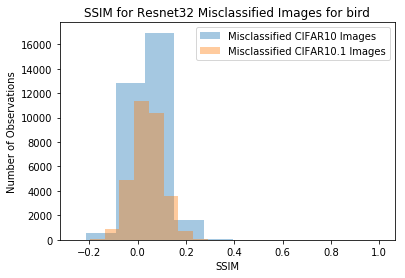

CIFAR10 SSIM Mean:      0.043684314941739105
CIFAR10.1 SSIM Mean:    0.041090840653051526
CIFAR10 SSIM Median:    0.04275827703866035
CIFAR10.1 SSIM Median:  0.040372942093628655


/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


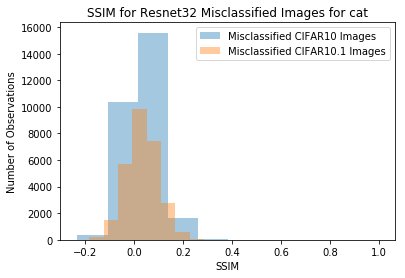

CIFAR10 SSIM Mean:      0.03652413861036556
CIFAR10.1 SSIM Mean:    0.034763109501906475
CIFAR10 SSIM Median:    0.035333861961095406
CIFAR10.1 SSIM Median:  0.03340079014903734


/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


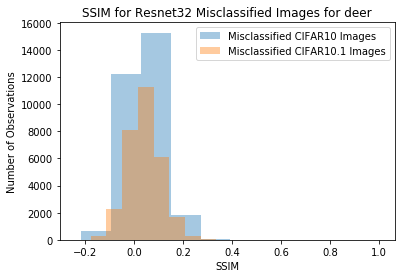

CIFAR10 SSIM Mean:      0.041485151844132144
CIFAR10.1 SSIM Mean:    0.04020419125593746
CIFAR10 SSIM Median:    0.03972506697088912
CIFAR10.1 SSIM Median:  0.03866021513066417


/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


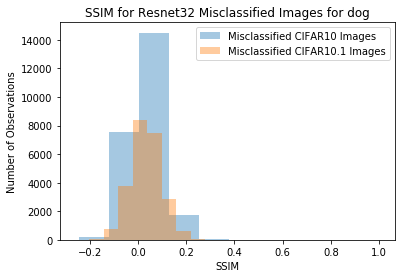

CIFAR10 SSIM Mean:      0.03563608405568938
CIFAR10.1 SSIM Mean:    0.03433760166820373
CIFAR10 SSIM Median:    0.034855722539247375
CIFAR10.1 SSIM Median:  0.03319793758678871


/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


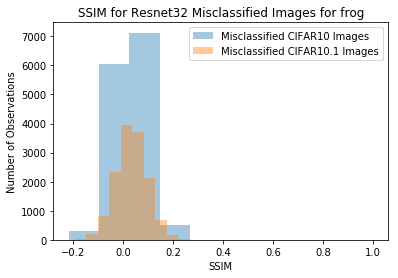

CIFAR10 SSIM Mean:      0.033474850059654164
CIFAR10.1 SSIM Mean:    0.034399659469464314
CIFAR10 SSIM Median:    0.03306810918882769
CIFAR10.1 SSIM Median:  0.03374953627468258


/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


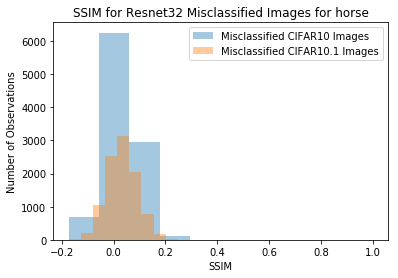

CIFAR10 SSIM Mean:      0.0323285384680746
CIFAR10.1 SSIM Mean:    0.03149809468117454
CIFAR10 SSIM Median:    0.031281324784393605
CIFAR10.1 SSIM Median:  0.030012292427267714


/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


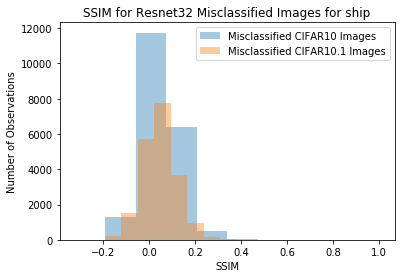

CIFAR10 SSIM Mean:      0.04931940706658871
CIFAR10.1 SSIM Mean:    0.04630734306583913
CIFAR10 SSIM Median:    0.045796022526411614
CIFAR10.1 SSIM Median:  0.043728847901854176


In [143]:
plot_SSIM_MSE_by_label(met_resnet32_ra_2_5, "Resnet32")

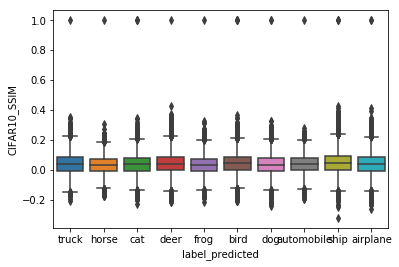

In [151]:
sns.boxplot(x="label_predicted", y="CIFAR10_SSIM", data=met_resnet32_ra_2_5);

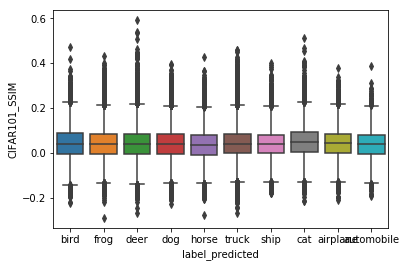

In [152]:
sns.boxplot(x="label_predicted", y="CIFAR101_SSIM", data=met_resnet32_ra_2_5_101);

/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/skimage/util/arraycrop.py:177: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  cropped = ar[slices]


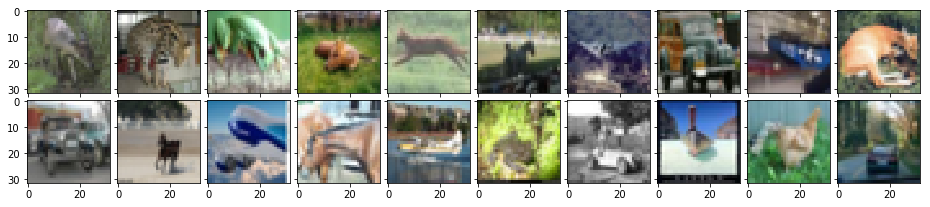

In [144]:
output = './resnet_basic_32_ra_2_5/predictions_400_refined50_CIFAR101.npz'
npzfile101 = np.load(output)
#confirm_score(npzfile101, test_labels_CIFAR101)
df_resnet32_errors_101_ra_2_5  = error_by_r_score(npzfile101, test_labels_CIFAR101, test_data_CIFAR101)
met_resnet32_ra_2_5_101 = calc_SSIM_MSE(df_resnet32_errors_101_ra_2_5, npzfile101)

/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


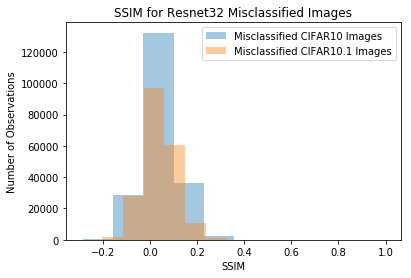

CIFAR10 SSIM Mean:      0.04404059684120017
CIFAR10.1 SSIM Mean:    0.041533411878772804
CIFAR10 SSIM Median:    0.041187455558374
CIFAR10.1 SSIM Median:  0.03926078986066224


In [145]:
plot_SSIM_MSE(met_resnet32_ra_2_5_101, "Resnet32")

/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


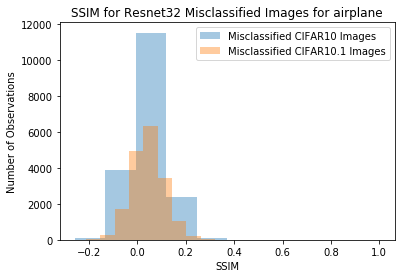

CIFAR10 SSIM Mean:      0.045390484446590044
CIFAR10.1 SSIM Mean:    0.04348070323983289
CIFAR10 SSIM Median:    0.04391664134272034
CIFAR10.1 SSIM Median:  0.04219323064608081


/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


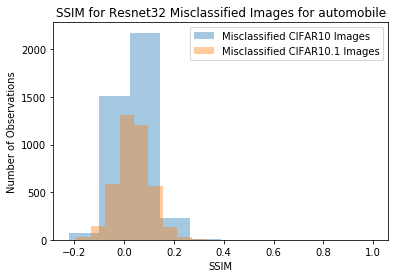

CIFAR10 SSIM Mean:      0.039745383258803106
CIFAR10.1 SSIM Mean:    0.037857991057431185
CIFAR10 SSIM Median:    0.039669042059826874
CIFAR10.1 SSIM Median:  0.03709925148336688


/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


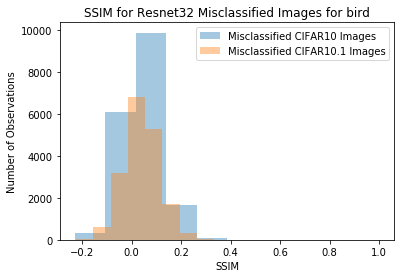

CIFAR10 SSIM Mean:      0.04447491707072875
CIFAR10.1 SSIM Mean:    0.04082581671880892
CIFAR10 SSIM Median:    0.04178470338196699
CIFAR10.1 SSIM Median:  0.03909828698613843


/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


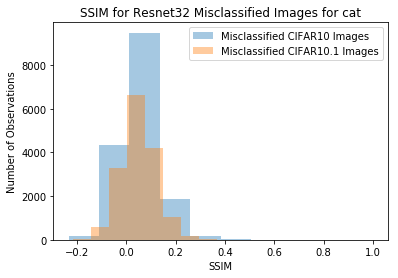

CIFAR10 SSIM Mean:      0.05486933131308869
CIFAR10.1 SSIM Mean:    0.05014753202768018
CIFAR10 SSIM Median:    0.05123897479770101
CIFAR10.1 SSIM Median:  0.04843343145199938


/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


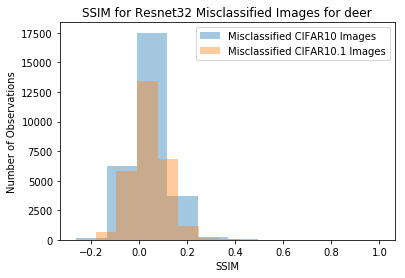

CIFAR10 SSIM Mean:      0.04209060072115785
CIFAR10.1 SSIM Mean:    0.04049289747871213
CIFAR10 SSIM Median:    0.038564466402200806
CIFAR10.1 SSIM Median:  0.03745448513268291


/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


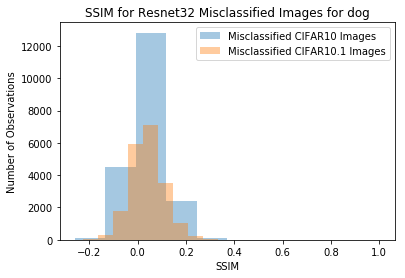

CIFAR10 SSIM Mean:      0.04166014397806377
CIFAR10.1 SSIM Mean:    0.040015348786096604
CIFAR10 SSIM Median:    0.03851051515358446
CIFAR10.1 SSIM Median:  0.03719787374921455


/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


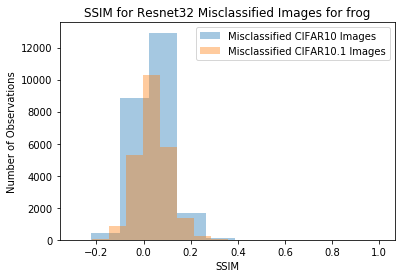

CIFAR10 SSIM Mean:      0.04318823326213491
CIFAR10.1 SSIM Mean:    0.040907201448307
CIFAR10 SSIM Median:    0.040048675447495234
CIFAR10.1 SSIM Median:  0.03824542245358015


/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


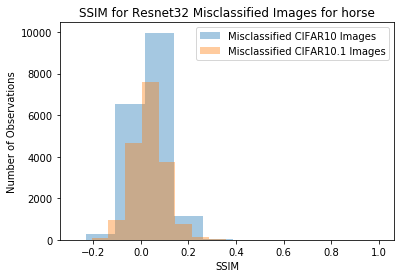

CIFAR10 SSIM Mean:      0.03817680976682889
CIFAR10.1 SSIM Mean:    0.03532494050684699
CIFAR10 SSIM Median:    0.03654851061783565
CIFAR10.1 SSIM Median:  0.03406972734834615


/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


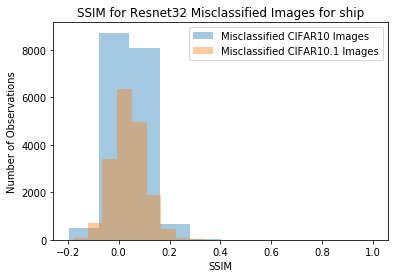

CIFAR10 SSIM Mean:      0.04282781264560171
CIFAR10.1 SSIM Mean:    0.04024714945844228
CIFAR10 SSIM Median:    0.04042875763807058
CIFAR10.1 SSIM Median:  0.03846139789341157


In [146]:
plot_SSIM_MSE_by_label(met_resnet32_ra_2_5_101, "Resnet32")

# resnet 32, ra 2 20

/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/skimage/util/arraycrop.py:177: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  cropped = ar[slices]


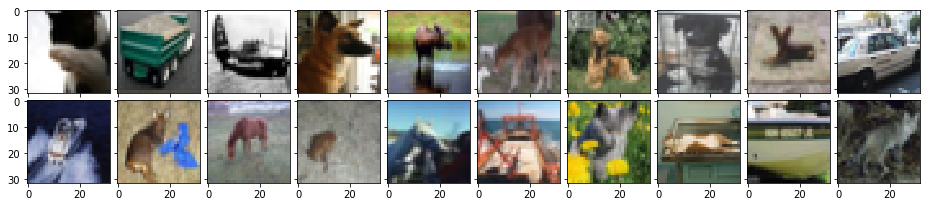

In [147]:

output = './resnet_basic_32_ra_2_20/predictions_400_refined50.npz'
npzfile = np.load(output)
#confirm_score(npzfile, test_labels_CIFAR10)
df_resnet32_errors_ra_2_20  = error_by_r_score(npzfile, test_labels_CIFAR10, test_data_CIFAR10)
met_resnet32_ra_2_20 = calc_SSIM_MSE(df_resnet32_errors_ra_2_20, npzfile)

/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


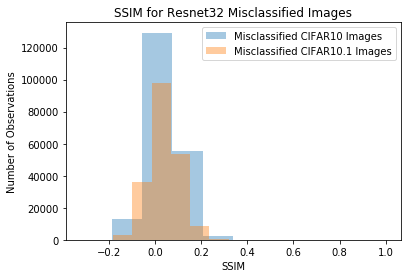

CIFAR10 SSIM Mean:      0.03970959374092367
CIFAR10.1 SSIM Mean:    0.03778333538775082
CIFAR10 SSIM Median:    0.03805364471936223
CIFAR10.1 SSIM Median:  0.03639149853592022


In [148]:
plot_SSIM_MSE(met_resnet32_ra_2_20, "Resnet32")

/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


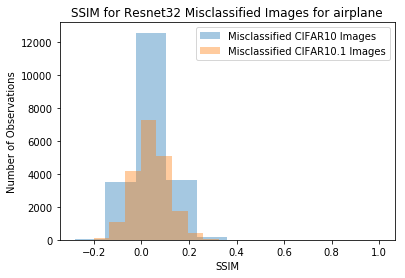

CIFAR10 SSIM Mean:      0.042223698750464986
CIFAR10.1 SSIM Mean:    0.040253671818012475
CIFAR10 SSIM Median:    0.04048078450602059
CIFAR10.1 SSIM Median:  0.03847478574633532


/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


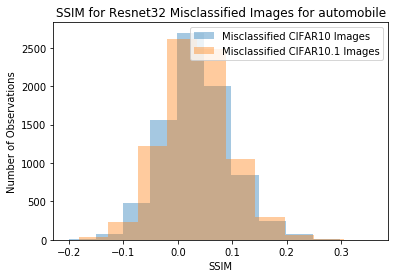

CIFAR10 SSIM Mean:      0.03627220497114529
CIFAR10.1 SSIM Mean:    0.034511094924286397
CIFAR10 SSIM Median:    0.03404300046648407
CIFAR10.1 SSIM Median:  0.03246176221395281


/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


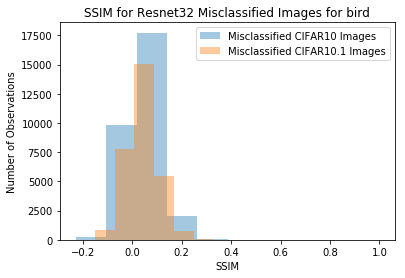

CIFAR10 SSIM Mean:      0.04472280105232905
CIFAR10.1 SSIM Mean:    0.04148944474935474
CIFAR10 SSIM Median:    0.042156136080223686
CIFAR10.1 SSIM Median:  0.03997271343034198


/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


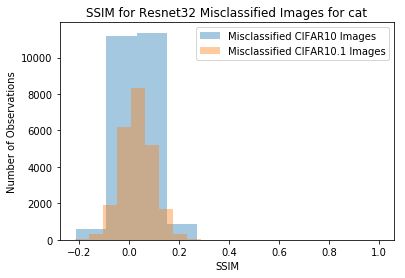

CIFAR10 SSIM Mean:      0.03233514767443677
CIFAR10.1 SSIM Mean:    0.03138447060408258
CIFAR10 SSIM Median:    0.03108556647130694
CIFAR10.1 SSIM Median:  0.02982433192636783


/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


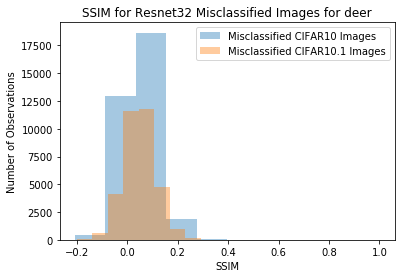

CIFAR10 SSIM Mean:      0.05220984804498671
CIFAR10.1 SSIM Mean:    0.050071540730284164
CIFAR10 SSIM Median:    0.0502668179329786
CIFAR10.1 SSIM Median:  0.04822406791889319


/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


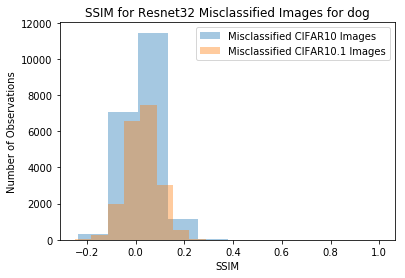

CIFAR10 SSIM Mean:      0.031220706847409116
CIFAR10.1 SSIM Mean:    0.029302454563288227
CIFAR10 SSIM Median:    0.03143693526314003
CIFAR10.1 SSIM Median:  0.02847001566559573


/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


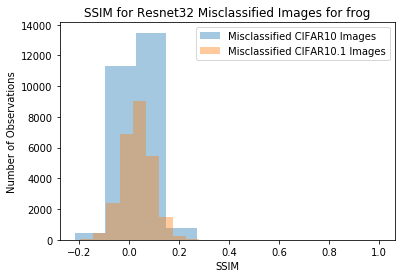

CIFAR10 SSIM Mean:      0.033121354998140035
CIFAR10.1 SSIM Mean:    0.03242381186133545
CIFAR10 SSIM Median:    0.03266641523064036
CIFAR10.1 SSIM Median:  0.03176317175244736


/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


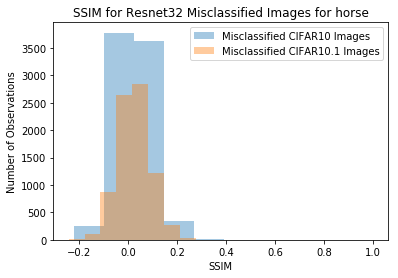

CIFAR10 SSIM Mean:      0.026372842080896568
CIFAR10.1 SSIM Mean:    0.02760766944124709
CIFAR10 SSIM Median:    0.024362373923692303
CIFAR10.1 SSIM Median:  0.02558265316970604


/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


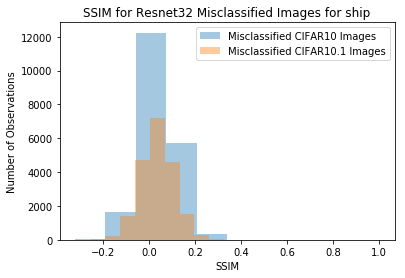

CIFAR10 SSIM Mean:      0.04050076863522984
CIFAR10.1 SSIM Mean:    0.03690431059857297
CIFAR10 SSIM Median:    0.037465195382504604
CIFAR10.1 SSIM Median:  0.03551377714665159


In [149]:
plot_SSIM_MSE_by_label(met_resnet32_ra_2_20, "Resnet32")

/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/skimage/util/arraycrop.py:177: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  cropped = ar[slices]


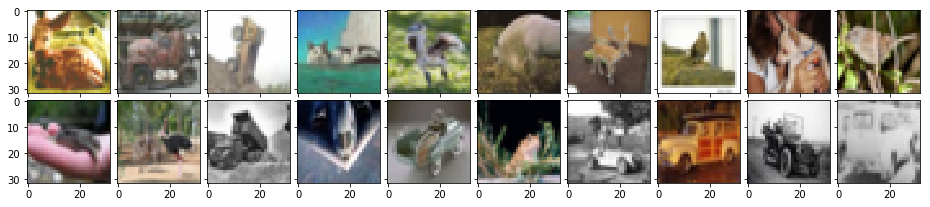

In [150]:
output = './resnet_basic_32_ra_2_20/predictions_400_refined50_CIFAR101.npz'
npzfile101 = np.load(output)
#confirm_score(npzfile101, test_labels_CIFAR101)
df_resnet32_errors_101_ra_2_20  = error_by_r_score(npzfile101, test_labels_CIFAR101, test_data_CIFAR101)
met_resnet32_ra_2_20_101 = calc_SSIM_MSE(df_resnet32_errors_101_ra_2_20, npzfile101)

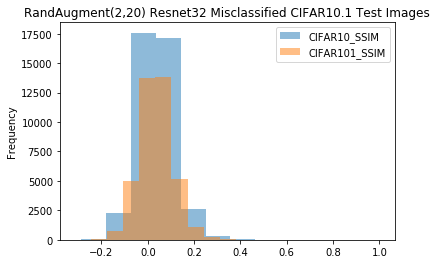

In [40]:
plot_SSIM_MSE(met_resnet32_ra_2_20_101, "Resnet32")

In [41]:
plot_SSIM_MSE_by_label(met_resnet32_ra_2_20_101, "Resnet32")

0.03845118393396442
0.03636508778438204
0.03567780470558897
0.0346096003931156


### resnet 32, ra 3 20

/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/skimage/util/arraycrop.py:177: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  cropped = ar[slices]


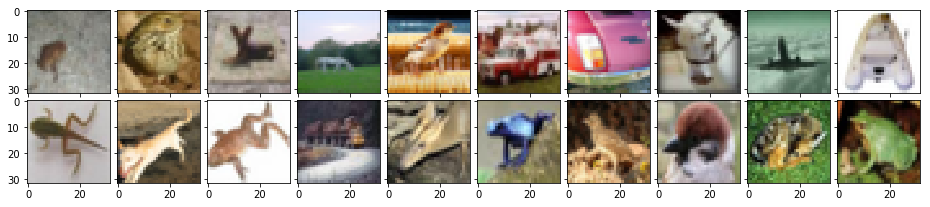

In [38]:
output = './resnet_basic_32_ra_3_20/predictions_400_refined50.npz'
npzfile = np.load(output)
#confirm_score(npzfile, test_labels_CIFAR10)
df_resnet32_errors_ra_3_20  = error_by_r_score(npzfile, test_labels_CIFAR10, test_data_CIFAR10)
met_resnet32_ra_3_20 = calc_SSIM_MSE(df_resnet32_errors_ra_3_20, npzfile)

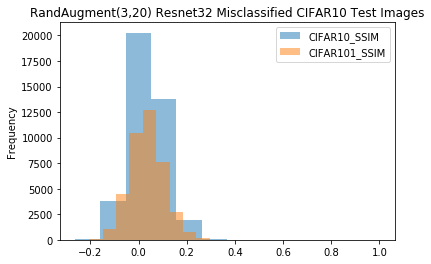

In [39]:
plot_SSIM_MSE(met_resnet32_ra_3_20, "Resnet32")

In [42]:
plot_SSIM_MSE_by_label(met_resnet32_ra_3_20, "Resnet32")

0.03685422140251175
0.0358622058750895
0.034804144911640036
0.034065955637844786


/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/skimage/util/arraycrop.py:177: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  cropped = ar[slices]


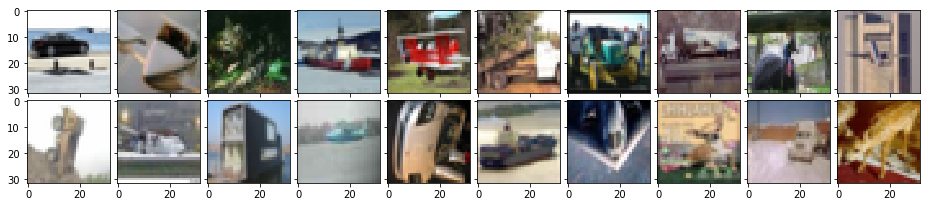

In [43]:
output = './resnet_basic_32_ra_3_20/predictions_400_refined50_CIFAR101.npz'
npzfile101 = np.load(output)
#confirm_score(npzfile101, test_labels_CIFAR101)
df_resnet32_errors_ra_3_20_101  = error_by_r_score(npzfile101, test_labels_CIFAR101, test_data_CIFAR101)
met_resnet32_ra_3_20_101 = calc_SSIM_MSE(df_resnet32_errors_ra_3_20_101, npzfile101)

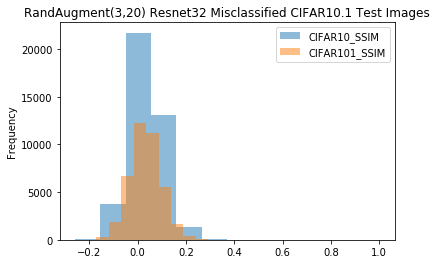

In [44]:
plot_SSIM_MSE(met_resnet32_ra_3_20_101, "Resnet32")

In [45]:
plot_SSIM_MSE_by_label(met_resnet32_ra_3_20_101, "Resnet32")

0.035545663929053437
0.03278153405804423
0.03366245275961917
0.03103064961260243


### now redo for wrn

### wrn_28_10, no RA

/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/skimage/util/arraycrop.py:177: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  cropped = ar[slices]


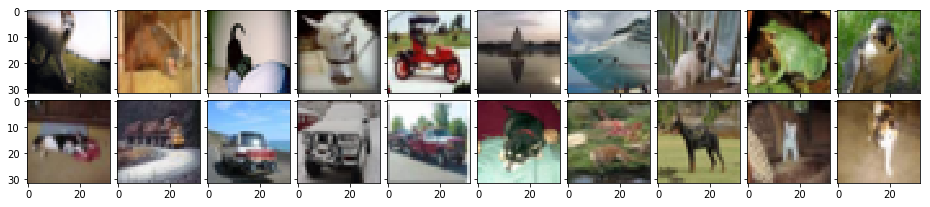

In [55]:
output = './wrn_28_10/predictions_200.npz'
npzfile = np.load(output)
#confirm_score(npzfile, test_labels_CIFAR10)
df_wrn28_errors_no_ra  = error_by_r_score(npzfile, test_labels_CIFAR10, test_data_CIFAR10)
met_wrn28_errors_no_ra = calc_SSIM_MSE(df_wrn28_errors_no_ra)

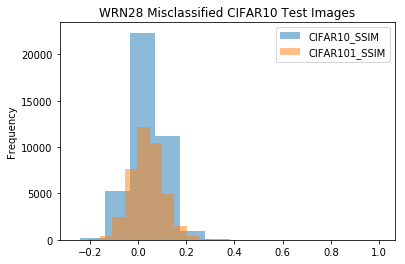

In [47]:
plt1 = met_wrn28_errors_no_ra['CIFAR10_SSIM'].plot.hist(bins=12, alpha=0.5, title='WRN28 Misclassified CIFAR10 Test Images', legend=1)
plt2 = met_wrn28_errors_no_ra['CIFAR101_SSIM'].plot.hist(bins=12, alpha=0.5, title='WRN28 Misclassified CIFAR10 Test Images', legend=1)

In [48]:
print(np.mean(met_wrn28_errors_no_ra['CIFAR10_SSIM']))
print(np.mean(met_wrn28_errors_no_ra['CIFAR101_SSIM']))
print(np.median(met_wrn28_errors_no_ra['CIFAR10_SSIM']))
print(np.median(met_wrn28_errors_no_ra['CIFAR101_SSIM']))

0.039491789276445755
0.03869698247690581
0.03763399969595331
0.037035035472064534


/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/skimage/util/arraycrop.py:177: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  cropped = ar[slices]


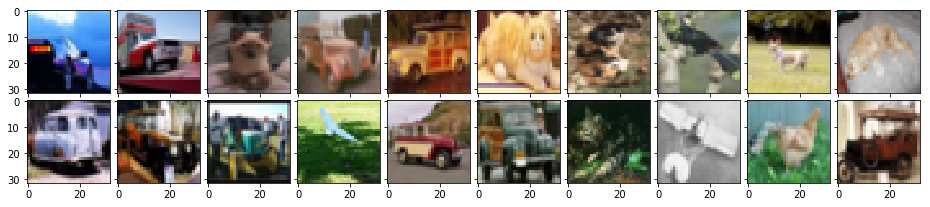

In [49]:
output = './wrn_28_10/predictions_200_CIFAR101.npz'
npzfile101 = np.load(output)
#confirm_score(npzfile101, test_labels_CIFAR101)
df_wrn28_errors_no_ra_101  = error_by_r_score(npzfile101, test_labels_CIFAR101, test_data_CIFAR101)
met_wrn28_errors_no_ra_101 = calc_SSIM_MSE(df_wrn28_errors_no_ra_101)

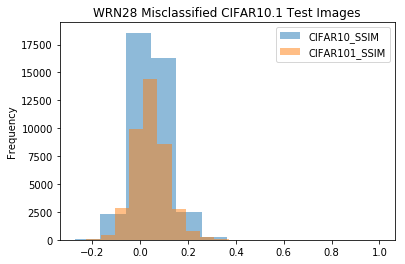

In [54]:
plt1 = met_wrn28_errors_no_ra_101['CIFAR10_SSIM'].plot.hist(bins=12, alpha=0.5, title='WRN28 Misclassified CIFAR10.1 Test Images', legend=1)
plt2 = met_wrn28_errors_no_ra_101['CIFAR101_SSIM'].plot.hist(bins=12, alpha=0.5, title='WRN28 Misclassified CIFAR10.1 Test Images', legend=1)

In [51]:
print(np.mean(met_wrn28_errors_no_ra_101['CIFAR10_SSIM']))
print(np.mean(met_wrn28_errors_no_ra_101['CIFAR101_SSIM']))
print(np.median(met_wrn28_errors_no_ra_101['CIFAR10_SSIM']))
print(np.median(met_wrn28_errors_no_ra_101['CIFAR101_SSIM']))

0.04594114769773488
0.04399904781016621
0.04253422544492517
0.040596654234725624


### wrn_28_10, RA(2,5)

/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/skimage/util/arraycrop.py:177: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  cropped = ar[slices]


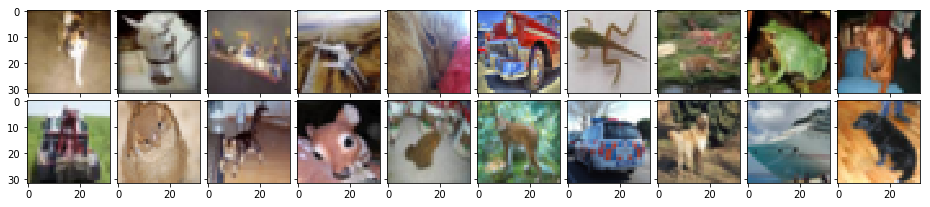

In [52]:
output = './wrn_28_10_ra_2_5/predictions_400_refined50.npz'
npzfile = np.load(output)
#confirm_score(npzfile, test_labels_CIFAR10)
df_wrn28_errors_ra_2_5  = error_by_r_score(npzfile, test_labels_CIFAR10, test_data_CIFAR10)
met_wrn28_errors_ra_2_5 = calc_SSIM_MSE(df_wrn28_errors_ra_2_5)

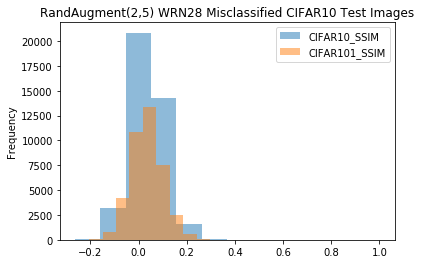

In [56]:
plt1 = met_wrn28_errors_ra_2_5['CIFAR10_SSIM'].plot.hist(bins=12, alpha=0.5, title='RandAugment(2,5) WRN28 Misclassified CIFAR10 Test Images', legend=1)
plt2 = met_wrn28_errors_ra_2_5['CIFAR101_SSIM'].plot.hist(bins=12, alpha=0.5, title='RandAugment(2,5) WRN28 Misclassified CIFAR10 Test Images', legend=1)

In [57]:
print(np.mean(met_wrn28_errors_ra_2_5['CIFAR10_SSIM']))
print(np.mean(met_wrn28_errors_ra_2_5['CIFAR101_SSIM']))
print(np.median(met_wrn28_errors_ra_2_5['CIFAR10_SSIM']))
print(np.median(met_wrn28_errors_ra_2_5['CIFAR101_SSIM']))

0.03786693502446
0.036067981694920606
0.03546757826428065
0.03410539909246593


/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/skimage/util/arraycrop.py:177: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  cropped = ar[slices]


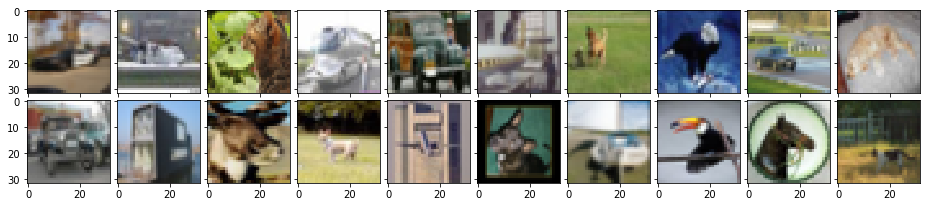

In [58]:
output = './wrn_28_10_ra_2_5/predictions_400_refined50_CIFAR101.npz'
npzfile101 = np.load(output)
#confirm_score(npzfile101, test_labels_CIFAR101)
df_wrn28_errors_ra_2_5_101  = error_by_r_score(npzfile101, test_labels_CIFAR101, test_data_CIFAR101)
met_wrn28_errors_ra_2_5_101 = calc_SSIM_MSE(df_wrn28_errors_ra_2_5_101)

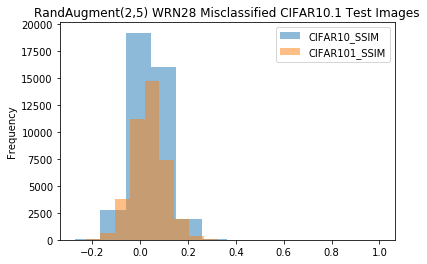

In [59]:
plt1 = met_wrn28_errors_ra_2_5_101['CIFAR10_SSIM'].plot.hist(bins=12, alpha=0.5, title='RandAugment(2,5) WRN28 Misclassified CIFAR10.1 Test Images', legend=1)
plt2 = met_wrn28_errors_ra_2_5_101['CIFAR101_SSIM'].plot.hist(bins=12, alpha=0.5, title='RandAugment(2,5) WRN28 Misclassified CIFAR10.1 Test Images', legend=1)

In [60]:
print(np.mean(met_wrn28_errors_ra_2_5_101['CIFAR10_SSIM']))
print(np.mean(met_wrn28_errors_ra_2_5_101['CIFAR101_SSIM']))
print(np.median(met_wrn28_errors_ra_2_5_101['CIFAR10_SSIM']))
print(np.median(met_wrn28_errors_ra_2_5_101['CIFAR101_SSIM']))

0.039403968046680164
0.036688667214454816
0.03785153360106506
0.03641059579207785


### wrn_28_10, RA(2,20)

/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/skimage/util/arraycrop.py:177: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  cropped = ar[slices]


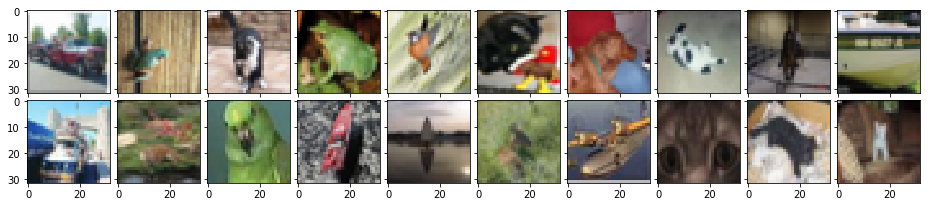

In [61]:
output = './wrn_28_10_ra_2_20/predictions_refined50.npz'
npzfile = np.load(output)
#confirm_score(npzfile, test_labels_CIFAR10)
df_wrn28_errors_ra_2_20  = error_by_r_score(npzfile, test_labels_CIFAR10, test_data_CIFAR10)
met_wrn28_errors_ra_2_20 = calc_SSIM_MSE(df_wrn28_errors_ra_2_20)

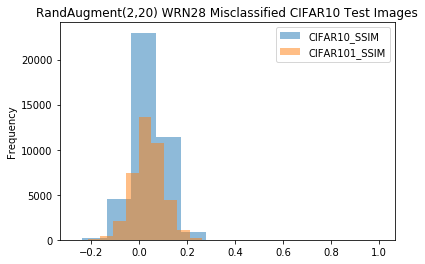

In [62]:
plt1 = met_wrn28_errors_ra_2_20['CIFAR10_SSIM'].plot.hist(bins=12, alpha=0.5, title='RandAugment(2,20) WRN28 Misclassified CIFAR10 Test Images', legend=1)
plt2 = met_wrn28_errors_ra_2_20['CIFAR101_SSIM'].plot.hist(bins=12, alpha=0.5, title='RandAugment(2,20) WRN28 Misclassified CIFAR10 Test Images', legend=1)

In [63]:
print(np.mean(met_wrn28_errors_ra_2_20['CIFAR10_SSIM']))
print(np.mean(met_wrn28_errors_ra_2_20['CIFAR101_SSIM']))
print(np.median(met_wrn28_errors_ra_2_20['CIFAR10_SSIM']))
print(np.median(met_wrn28_errors_ra_2_20['CIFAR101_SSIM']))

0.041198803351616034
0.03902869807739894
0.03999750050676023
0.03796882780102301


/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/skimage/util/arraycrop.py:177: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  cropped = ar[slices]


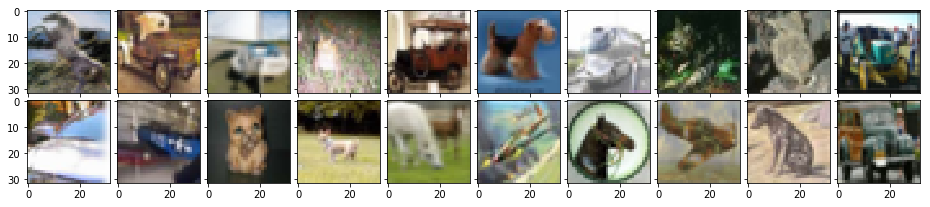

In [64]:
output = './wrn_28_10_ra_2_20/predictions_refined50_CIFAR101.npz'
npzfile101 = np.load(output)
#confirm_score(npzfile101, test_labels_CIFAR101)
df_wrn28_errors_ra_2_20_101  = error_by_r_score(npzfile101, test_labels_CIFAR101, test_data_CIFAR101)
met_wrn28_errors_ra_2_20_101 = calc_SSIM_MSE(df_wrn28_errors_ra_2_20_101)

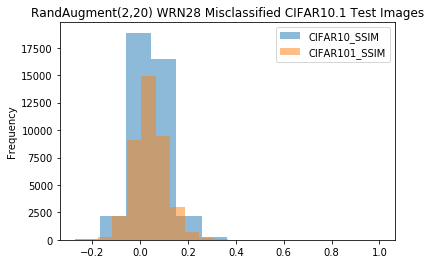

In [65]:
plt1 = met_wrn28_errors_ra_2_20_101['CIFAR10_SSIM'].plot.hist(bins=12, alpha=0.5, title='RandAugment(2,20) WRN28 Misclassified CIFAR10.1 Test Images', legend=1)
plt2 = met_wrn28_errors_ra_2_20_101['CIFAR101_SSIM'].plot.hist(bins=12, alpha=0.5, title='RandAugment(2,20) WRN28 Misclassified CIFAR10.1 Test Images', legend=1)

In [66]:
print(np.mean(met_wrn28_errors_ra_2_20_101['CIFAR10_SSIM']))
print(np.mean(met_wrn28_errors_ra_2_20_101['CIFAR101_SSIM']))
print(np.median(met_wrn28_errors_ra_2_20_101['CIFAR10_SSIM']))
print(np.median(met_wrn28_errors_ra_2_20_101['CIFAR101_SSIM']))

0.04516970451758379
0.04179788886976685
0.041865488736514495
0.0392550253809751


### wrn_28_10, RA(3,20)

/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/skimage/util/arraycrop.py:177: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  cropped = ar[slices]


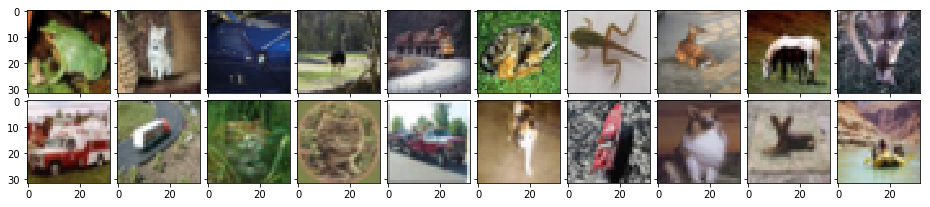

In [67]:
output = './wrn_28_10_ra_3_20/predictions_400_refined50.npz'
npzfile = np.load(output)
#confirm_score(npzfile, test_labels_CIFAR10)
df_wrn28_errors_ra_3_20  = error_by_r_score(npzfile, test_labels_CIFAR10, test_data_CIFAR10)
met_wrn28_errors_ra_3_20 = calc_SSIM_MSE(df_wrn28_errors_ra_3_20)

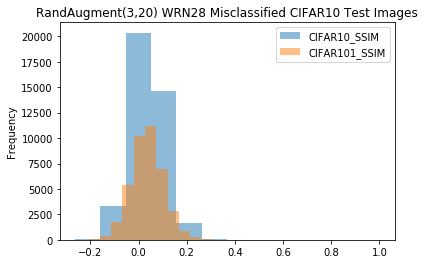

In [68]:
plt1 = met_wrn28_errors_ra_3_20['CIFAR10_SSIM'].plot.hist(bins=12, alpha=0.5, title='RandAugment(3,20) WRN28 Misclassified CIFAR10 Test Images', legend=1)
plt2 = met_wrn28_errors_ra_3_20['CIFAR101_SSIM'].plot.hist(bins=12, alpha=0.5, title='RandAugment(3,20) WRN28 Misclassified CIFAR10 Test Images', legend=1)

In [69]:
print(np.mean(met_wrn28_errors_ra_3_20['CIFAR10_SSIM']))
print(np.mean(met_wrn28_errors_ra_3_20['CIFAR101_SSIM']))
print(np.median(met_wrn28_errors_ra_3_20['CIFAR10_SSIM']))
print(np.median(met_wrn28_errors_ra_3_20['CIFAR101_SSIM']))

0.0382926082469792
0.03706070426502163
0.03678770724564952
0.035769399517347644


/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/skimage/util/arraycrop.py:177: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  cropped = ar[slices]


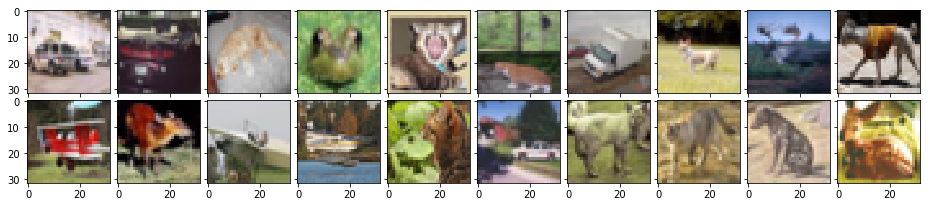

In [71]:
output = './wrn_28_10_ra_3_20/predictions_400_refined50_CIFAR101.npz'
npzfile101 = np.load(output)
# confirm_score(npzfile101, test_labels_CIFAR101)
df_wrn28_errors_ra_3_20_101  = error_by_r_score(npzfile101, test_labels_CIFAR101, test_data_CIFAR101)
met_wrn28_errors_ra_3_20_101 = calc_SSIM_MSE(df_wrn28_errors_ra_3_20_101)

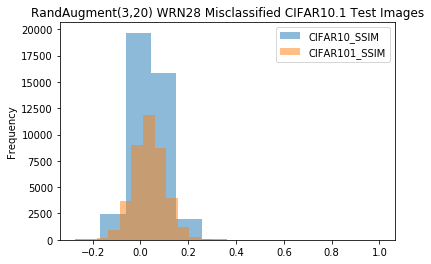

In [72]:
plt1 = met_wrn28_errors_ra_3_20_101['CIFAR10_SSIM'].plot.hist(bins=12, alpha=0.5, title='RandAugment(3,20) WRN28 Misclassified CIFAR10.1 Test Images', legend=1)
plt2 = met_wrn28_errors_ra_3_20_101['CIFAR101_SSIM'].plot.hist(bins=12, alpha=0.5, title='RandAugment(3,20) WRN28 Misclassified CIFAR10.1 Test Images', legend=1)

In [73]:
print(np.mean(met_wrn28_errors_ra_3_20_101['CIFAR10_SSIM']))
print(np.mean(met_wrn28_errors_ra_3_20_101['CIFAR101_SSIM']))
print(np.median(met_wrn28_errors_ra_3_20_101['CIFAR10_SSIM']))
print(np.median(met_wrn28_errors_ra_3_20_101['CIFAR101_SSIM']))

0.03846450026845307
0.036619626452239776
0.03616453753814081
0.03521567620528255


### now densenet

In [252]:
output = './densenet_BC_100_12/predictions_300.npz'
npzfile = np.load(output)
confirm_score(npzfile, test_labels_CIFAR10)


Accuracy: 0.9484
 -> Sanity Check: 9484 of 10000 correct

              precision  recall  f1-score     support
0 airplane     0.951244  0.9560  0.953616   1000.0000
1 automobile   0.971087  0.9740  0.972541   1000.0000
2 bird         0.955533  0.9240  0.939502   1000.0000
3 cat          0.899288  0.8840  0.891578   1000.0000
4  deer        0.937683  0.9630  0.950173   1000.0000
5 dog          0.898354  0.9280  0.912937   1000.0000
6 frog         0.966000  0.9660  0.966000   1000.0000
7 horse        0.983673  0.9640  0.973737   1000.0000
8 ship         0.954769  0.9710  0.962816   1000.0000
9 truck        0.968528  0.9540  0.961209   1000.0000
accuracy       0.948400  0.9484  0.948400      0.9484
macro avg      0.948616  0.9484  0.948411  10000.0000
weighted avg   0.948616  0.9484  0.948411  10000.0000


In [253]:
output = './densenet_BC_100_12/predictions_300_CIFAR101.npz'
npzfile101 = np.load(output)
confirm_score(npzfile101, test_labels_CIFAR101)


Accuracy: 0.883
 -> Sanity Check: 0 of 2000 correct

              precision  recall  f1-score   support
0 airplane     0.859296   0.855  0.857143   200.000
1 automobile   0.968354   0.765  0.854749   200.000
2 bird         0.873171   0.895  0.883951   200.000
3 cat          0.851064   0.800  0.824742   200.000
4  deer        0.898551   0.930  0.914005   200.000
5 dog          0.864322   0.860  0.862155   200.000
6 frog         0.921182   0.935  0.928040   200.000
7 horse        0.939394   0.930  0.934673   200.000
8 ship         0.858491   0.910  0.883495   200.000
9 truck        0.822511   0.950  0.881671   200.000
accuracy       0.883000   0.883  0.883000     0.883
macro avg      0.885634   0.883  0.882462  2000.000
weighted avg   0.885634   0.883  0.882462  2000.000


/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/ipykernel/__main__.py:30: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


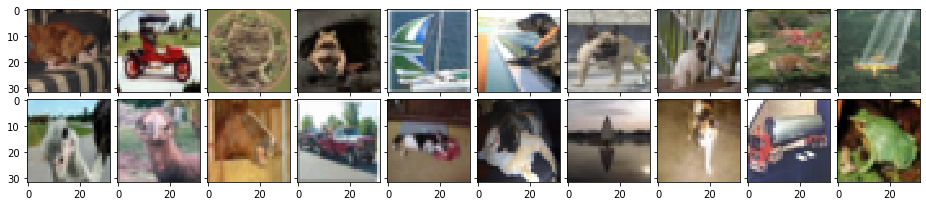

In [254]:
df_densenet_errors = error_by_r_score(npzfile, test_labels_CIFAR10, test_data_CIFAR10)

In [255]:
df_densenet_errors

prob_predicted  prob_correct       r_value  label_predicted_id  \
0         0.999986  1.330717e-05  7.514643e+04                   3   
1         0.999588  1.096647e-05  9.114944e+04                   9   
2         0.999925  1.023711e-05  9.767648e+04                   6   
3         0.995281  7.736055e-06  1.286549e+05                   5   
4         0.999388  6.549802e-06  1.525830e+05                   0   
5         0.887884  5.223285e-06  1.699857e+05                   1   
6         0.807098  4.371054e-06  1.846460e+05                   5   
7         0.999940  5.301942e-06  1.885988e+05                   5   
8         0.999968  2.706531e-06  3.694648e+05                   4   
9         0.999197  1.989888e-06  5.021373e+05                   8   
10        0.999782  1.330388e-06  7.514962e+05                   5   
11        0.977794  8.521764e-07  1.147408e+06                   4   
12        0.999749  5.940653e-07  1.682894e+06                   3   
13        0.999999  5.896199e-07  1.696007e+06                   9   
14        0.999909  5.491632e-07  1.820786e+06                   5   
15        1.000000  2.291939e-07  4.363117e+06                   5   
16        1.000000  1.532814e-07  6.523949e+06                   0   
17        1.000000  1.085486e-07  9.212465e+06                   5   
18        1.000000  8.656756e-08  1.155167e+07                   0   
19        0.999938  2.747537e-08  3.639398e+07                   6   

   label_predicted  correct_label correct_label_id  img_index  
0              cat              5              dog       5830  
1            truck              1       automobile       1969  
2             frog              3              cat       5511  
3              dog              6             frog       8728  
4         airplane              8             ship       1772  
5       automobile              5              dog       2525  
6              dog              3              cat       2804  
7              dog              3              cat       4614  
8             deer              3              cat       4965  
9             ship              0         airplane        378  
10             dog              2             bird       7657  
11            deer              2             bird       2592  
12             cat              7            horse       6151  
13           truck              1       automobile       9227  
14             dog              3              cat       7509  
15             dog              3              cat       9431  
16        airplane              8             ship       5548  
17             dog              3              cat       7099  
18        airplane              9            truck       6741  
19            frog              3              cat       2405

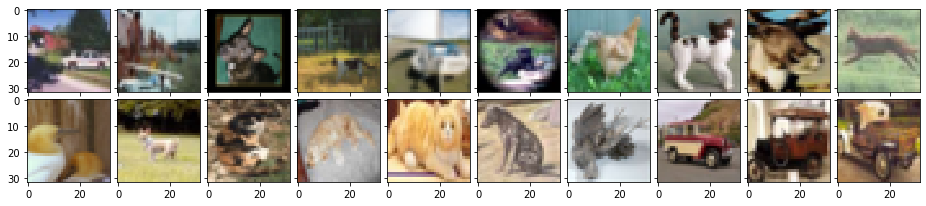

In [256]:
df_densenet_errors_101  = error_by_r_score(npzfile101, test_labels_CIFAR101, test_data_CIFAR101)

In [257]:
df_densenet_errors_101

prob_predicted  prob_correct       r_value  label_predicted_id  \
0         0.965693  1.702146e-04  5.673386e+03                   9   
1         0.985442  1.526594e-04  6.455169e+03                   8   
2         0.999797  1.389711e-04  7.194279e+03                   3   
3         0.994349  1.198931e-04  8.293630e+03                   4   
4         0.996554  1.052018e-04  9.472788e+03                   0   
5         0.905748  8.101539e-05  1.117995e+04                   8   
6         0.992400  6.888977e-05  1.440562e+04                   3   
7         0.999931  6.916542e-05  1.445709e+04                   5   
8         0.999896  5.984369e-05  1.670847e+04                   3   
9         0.928986  4.205892e-05  2.208772e+04                   7   
10        0.979044  2.712986e-05  3.608733e+04                   3   
11        0.998892  2.554665e-05  3.910070e+04                   4   
12        0.999766  1.169858e-05  8.546048e+04                   5   
13        0.999973  5.553322e-06  1.800676e+05                   3   
14        0.999634  4.331972e-06  2.307571e+05                   5   
15        0.998626  4.192331e-06  2.382030e+05                   3   
16        0.999318  3.548552e-06  2.816128e+05                   3   
17        0.999998  1.154429e-06  8.662274e+05                   9   
18        0.999990  1.980956e-07  5.048014e+06                   9   
19        0.999998  1.354108e-07  7.384922e+06                   9   

   label_predicted  correct_label correct_label_id  img_index  
0            truck              1       automobile        365  
1             ship              0         airplane         76  
2              cat              5              dog       1126  
3             deer              3              cat        772  
4         airplane              8             ship       1753  
5             ship              5              dog       1060  
6              cat              2             bird        592  
7              dog              3              cat        600  
8              cat              4             deer        996  
9            horse              3              cat        671  
10             cat              2             bird        420  
11            deer              5              dog       1076  
12             dog              3              cat        783  
13             cat              5              dog       1134  
14             dog              3              cat        602  
15             cat              5              dog       1148  
16             cat              2             bird        433  
17           truck              1       automobile        254  
18           truck              1       automobile        391  
19           truck              1       automobile        336

### densenet, no RA

### densenet, RA(2,5)

In [258]:
output = './densenet_BC_100_12_ra_2_5/predictions_400_refined50.npz'
npzfile = np.load(output)
confirm_score(npzfile, test_labels_CIFAR10)


Accuracy: 0.9313
 -> Sanity Check: 9313 of 10000 correct

              precision  recall  f1-score     support
0 airplane     0.930898  0.9430  0.936910   1000.0000
1 automobile   0.973843  0.9680  0.970913   1000.0000
2 bird         0.913828  0.9120  0.912913   1000.0000
3 cat          0.872497  0.8280  0.849666   1000.0000
4  deer        0.928571  0.9360  0.932271   1000.0000
5 dog          0.896130  0.8800  0.887992   1000.0000
6 frog         0.936461  0.9580  0.947108   1000.0000
7 horse        0.954092  0.9560  0.955045   1000.0000
8 ship         0.954545  0.9660  0.960239   1000.0000
9 truck        0.947988  0.9660  0.956909   1000.0000
accuracy       0.931300  0.9313  0.931300      0.9313
macro avg      0.930886  0.9313  0.930997  10000.0000
weighted avg   0.930886  0.9313  0.930997  10000.0000


In [259]:
output = './densenet_BC_100_12_ra_2_5/predictions_400_refined50_CIFAR101.npz'
npzfile101 = np.load(output)
confirm_score(npzfile101, test_labels_CIFAR101)


Accuracy: 0.847
 -> Sanity Check: 0 of 2000 correct

              precision  recall  f1-score   support
0 airplane     0.814634   0.835  0.824691   200.000
1 automobile   0.968153   0.760  0.851541   200.000
2 bird         0.843137   0.860  0.851485   200.000
3 cat          0.779570   0.725  0.751295   200.000
4  deer        0.835681   0.890  0.861985   200.000
5 dog          0.837696   0.800  0.818414   200.000
6 frog         0.884615   0.920  0.901961   200.000
7 horse        0.878049   0.900  0.888889   200.000
8 ship         0.852217   0.865  0.858561   200.000
9 truck        0.802632   0.915  0.855140   200.000
accuracy       0.847000   0.847  0.847000     0.847
macro avg      0.849638   0.847  0.846396  2000.000
weighted avg   0.849638   0.847  0.846396  2000.000


/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/ipykernel/__main__.py:30: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


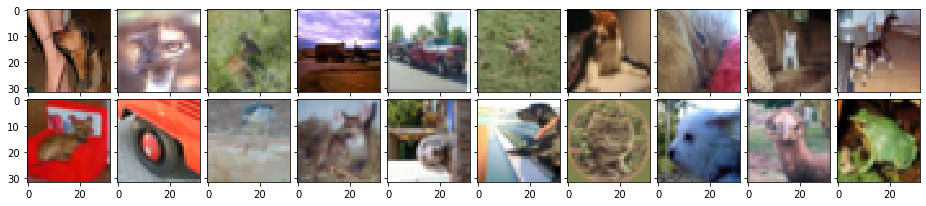

In [260]:
df_densenet_ra_2_5_errors = error_by_r_score(npzfile, test_labels_CIFAR10, test_data_CIFAR10)

In [261]:
df_densenet_ra_2_5_errors

prob_predicted  prob_correct       r_value  label_predicted_id  \
0         0.800650  9.851829e-06  8.126917e+04                   3   
1         0.992131  1.217273e-05  8.150434e+04                   3   
2         0.998805  1.159369e-05  8.615071e+04                   2   
3         0.999989  1.128641e-05  8.860115e+04                   0   
4         0.999993  6.264517e-06  1.596281e+05                   9   
5         0.999992  5.347182e-06  1.870130e+05                   4   
6         0.999995  4.692158e-06  2.131205e+05                   5   
7         0.997054  4.320059e-06  2.307963e+05                   4   
8         0.999801  2.758338e-06  3.624649e+05                   3   
9         0.999913  2.158153e-06  4.633190e+05                   7   
10        0.999997  1.850948e-06  5.402618e+05                   3   
11        0.796703  1.466766e-06  5.431698e+05                   3   
12        0.999881  1.716580e-06  5.824845e+05                   4   
13        0.999995  1.382798e-06  7.231681e+05                   3   
14        0.999991  1.307265e-06  7.649491e+05                   3   
15        0.446514  3.351588e-07  1.332246e+06                   8   
16        0.999998  6.823525e-07  1.465516e+06                   6   
17        0.999876  2.778032e-07  3.599223e+06                   2   
18        0.997195  9.759902e-08  1.021726e+07                   7   
19        1.000000  8.817352e-11  1.134127e+10                   6   

   label_predicted  correct_label correct_label_id  img_index  
0              cat              5              dog       2061  
1              cat              2             bird       5862  
2             bird              4             deer       9386  
3         airplane              9            truck       3957  
4            truck              1       automobile       9227  
5             deer              2             bird       1325  
6              dog              3              cat         61  
7             deer              3              cat        916  
8              cat              5              dog       4740  
9            horse              3              cat       4485  
10             cat              5              dog       8469  
11             cat              9            truck       3789  
12            deer              2             bird       1248  
13             cat              4             deer       5417  
14             cat              5              dog       7620  
15            ship              5              dog       2525  
16            frog              3              cat       5511  
17            bird              5              dog       5098  
18           horse              2             bird       2592  
19            frog              3              cat       2405

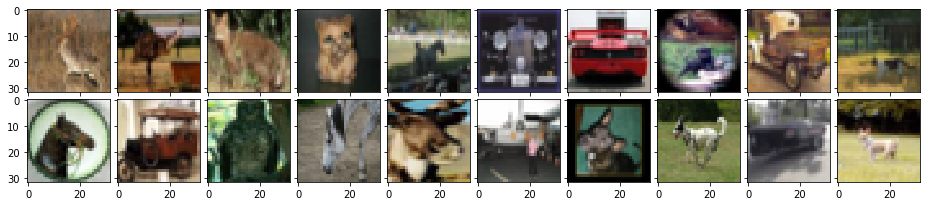

In [262]:
df_densenet_ra_2_5_errors_101  = error_by_r_score(npzfile101, test_labels_CIFAR101, test_data_CIFAR101)

In [263]:
df_densenet_ra_2_5_errors_101

prob_predicted  prob_correct       r_value  label_predicted_id  \
0         0.999802  6.228522e-05  1.605199e+04                   2   
1         0.956955  4.801135e-05  1.993185e+04                   7   
2         0.999263  4.995008e-05  2.000524e+04                   4   
3         0.999954  4.431286e-05  2.256578e+04                   5   
4         0.872498  2.953563e-05  2.954052e+04                   0   
5         0.982307  1.678094e-05  5.853705e+04                   9   
6         0.995198  1.523278e-05  6.533263e+04                   9   
7         0.713014  1.080462e-05  6.599159e+04                   8   
8         0.999896  1.397156e-05  7.156654e+04                   9   
9         0.995222  1.112393e-05  8.946680e+04                   4   
10        0.939889  7.667076e-06  1.225876e+05                   3   
11        0.999982  7.896424e-06  1.266373e+05                   9   
12        0.999739  7.490507e-06  1.334674e+05                   3   
13        0.998065  4.886333e-06  2.042565e+05                   2   
14        0.957278  4.119330e-06  2.323868e+05                   5   
15        0.999655  3.157935e-06  3.165533e+05                   9   
16        0.999967  3.073024e-06  3.254014e+05                   3   
17        0.997234  1.984343e-06  5.025512e+05                   2   
18        0.596461  4.691775e-07  1.271290e+06                   9   
19        0.999977  9.015311e-08  1.109198e+07                   4   

   label_predicted  correct_label correct_label_id  img_index  
0             bird              4             deer        977  
1            horse              2             bird        571  
2             deer              3              cat        668  
3              dog              3              cat        757  
4         airplane              7            horse       1426  
5            truck              1       automobile        382  
6            truck              1       automobile        309  
7             ship              5              dog       1060  
8            truck              1       automobile        336  
9             deer              3              cat        772  
10             cat              7            horse       1412  
11           truck              1       automobile        391  
12             cat              2             bird        528  
13            bird              7            horse       1414  
14             dog              4             deer        996  
15           truck              0         airplane        167  
16             cat              5              dog       1126  
17            bird              5              dog       1117  
18           truck              8             ship       1623  
19            deer              5              dog       1076

### densenet, RA(2,20)

In [264]:
output = './densenet_BC_100_12_ra_2_20/predictions_refined50.npz'
npzfile = np.load(output)
confirm_score(npzfile, test_labels_CIFAR10)


Accuracy: 0.9168
 -> Sanity Check: 9168 of 10000 correct

              precision  recall  f1-score     support
0 airplane     0.921569  0.9400  0.930693   1000.0000
1 automobile   0.960199  0.9650  0.962594   1000.0000
2 bird         0.899696  0.8880  0.893810   1000.0000
3 cat          0.791825  0.8330  0.811891   1000.0000
4  deer        0.925553  0.9200  0.922768   1000.0000
5 dog          0.883103  0.8310  0.856260   1000.0000
6 frog         0.940358  0.9460  0.943170   1000.0000
7 horse        0.955010  0.9340  0.944388   1000.0000
8 ship         0.951244  0.9560  0.953616   1000.0000
9 truck        0.943676  0.9550  0.949304   1000.0000
accuracy       0.916800  0.9168  0.916800      0.9168
macro avg      0.917223  0.9168  0.916849  10000.0000
weighted avg   0.917223  0.9168  0.916849  10000.0000


In [265]:
output = './densenet_BC_100_12_ra_2_20/predictions_refined50_CIFAR101.npz'
npzfile101 = np.load(output)
confirm_score(npzfile101, test_labels_CIFAR101)


Accuracy: 0.829
 -> Sanity Check: 0 of 2000 correct

              precision  recall  f1-score   support
0 airplane     0.798030   0.810  0.803970   200.000
1 automobile   0.949045   0.745  0.834734   200.000
2 bird         0.803922   0.820  0.811881   200.000
3 cat          0.714286   0.750  0.731707   200.000
4  deer        0.841837   0.825  0.833333   200.000
5 dog          0.819149   0.770  0.793814   200.000
6 frog         0.897959   0.880  0.888889   200.000
7 horse        0.873096   0.860  0.866499   200.000
8 ship         0.866029   0.905  0.885086   200.000
9 truck        0.770833   0.925  0.840909   200.000
accuracy       0.829000   0.829  0.829000     0.829
macro avg      0.833418   0.829  0.829082  2000.000
weighted avg   0.833418   0.829  0.829082  2000.000


/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/ipykernel/__main__.py:30: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


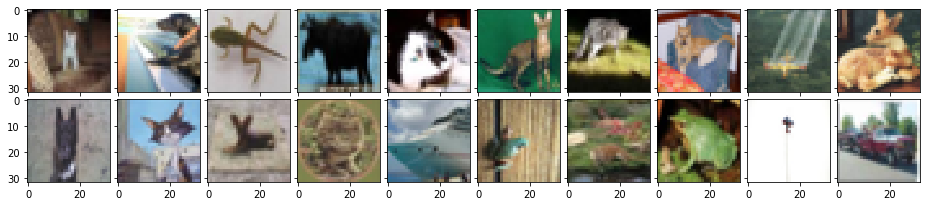

In [266]:
df_densenet_ra_2_20_errors = error_by_r_score(npzfile, test_labels_CIFAR10, test_data_CIFAR10)

In [267]:
df_densenet_ra_2_20_errors

prob_predicted  prob_correct       r_value  label_predicted_id  \
0         0.993151  3.740463e-05  2.655154e+04                   3   
1         0.926264  2.883286e-05  3.212528e+04                   2   
2         0.999909  2.832835e-05  3.529712e+04                   0   
3         0.999974  2.606528e-05  3.836421e+04                   7   
4         0.999979  1.506740e-05  6.636705e+04                   5   
5         0.999803  1.054540e-05  9.480935e+04                   4   
6         0.999728  7.905124e-06  1.264658e+05                   2   
7         0.999989  6.876061e-06  1.454306e+05                   3   
8         0.999993  3.932442e-06  2.542932e+05                   8   
9         0.681665  2.524843e-06  2.699832e+05                   3   
10        0.999993  3.174373e-06  3.150207e+05                   3   
11        0.870594  2.138615e-06  4.070832e+05                   0   
12        0.999398  2.159006e-06  4.628973e+05                   4   
13        0.999981  1.367727e-06  7.311261e+05                   6   
14        0.999999  1.073481e-06  9.315473e+05                   0   
15        0.937417  3.583740e-07  2.615750e+06                   2   
16        0.999972  2.137104e-07  4.679098e+06                   4   
17        1.000000  7.223171e-08  1.384433e+07                   6   
18        1.000000  2.468465e-08  4.051100e+07                   2   
19        1.000000  2.244851e-08  4.454638e+07                   9   

   label_predicted  correct_label correct_label_id  img_index  
0              cat              5              dog       4740  
1             bird              5              dog       2525  
2         airplane              6             frog       8573  
3            horse              4             deer       9840  
4              dog              3              cat       7384  
5             deer              3              cat       7881  
6             bird              3              cat       5908  
7              cat              5              dog       4051  
8             ship              0         airplane        378  
9              cat              4             deer       3297  
10             cat              5              dog       2161  
11        airplane              3              cat       8778  
12            deer              5              dog       3192  
13            frog              3              cat       5511  
14        airplane              8             ship        665  
15            bird              6             frog       1935  
16            deer              3              cat       4965  
17            frog              3              cat       2405  
18            bird              0         airplane       3444  
19           truck              1       automobile       9227

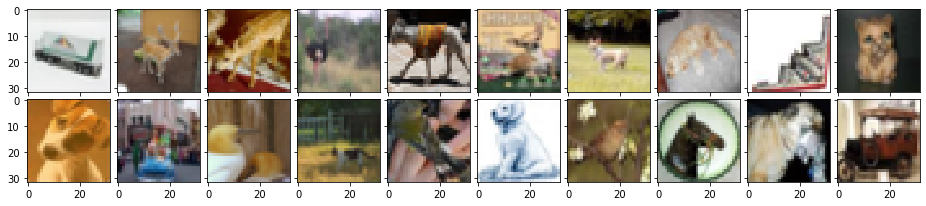

In [268]:
df_densenet_ra_2_20_errors_101  = error_by_r_score(npzfile101, test_labels_CIFAR101, test_data_CIFAR101)

In [269]:
df_densenet_ra_2_20_errors_101

prob_predicted  prob_correct       r_value  label_predicted_id  \
0         0.764676  1.927351e-04  3.967497e+03                   0   
1         0.950902  2.189423e-04  4.343162e+03                   0   
2         0.950164  2.062789e-04  4.606210e+03                   6   
3         0.921630  1.831568e-04  5.031919e+03                   5   
4         0.999746  1.773234e-04  5.637982e+03                   7   
5         0.997061  1.382615e-04  7.211412e+03                   4   
6         0.999184  1.225480e-04  8.153408e+03                   4   
7         0.770954  6.096006e-05  1.264688e+04                   3   
8         0.995199  7.638460e-05  1.302879e+04                   3   
9         0.999945  5.403101e-05  1.850687e+04                   5   
10        0.999428  2.864468e-05  3.489052e+04                   3   
11        0.997520  2.337239e-05  4.267943e+04                   9   
12        0.946385  2.039528e-05  4.640215e+04                   3   
13        0.999721  1.350421e-05  7.403030e+04                   4   
14        0.994212  7.407912e-06  1.342095e+05                   3   
15        0.996286  4.831360e-06  2.062124e+05                   3   
16        0.990133  3.437658e-06  2.880256e+05                   6   
17        0.832951  2.055255e-06  4.052785e+05                   3   
18        0.999996  3.569143e-07  2.801782e+06                   7   
19        0.999775  6.696280e-08  1.493031e+07                   9   

   label_predicted  correct_label correct_label_id  img_index  
0         airplane              9            truck       1973  
1         airplane              4             deer        837  
2             frog              4             deer        910  
3              dog              2             bird        482  
4            horse              5              dog       1121  
5             deer              5              dog       1072  
6             deer              5              dog       1076  
7              cat              5              dog       1134  
8              cat              0         airplane          7  
9              dog              3              cat        757  
10             cat              5              dog       1139  
11           truck              1       automobile        381  
12             cat              2             bird        420  
13            deer              3              cat        772  
14             cat              2             bird        426  
15             cat              5              dog       1045  
16            frog              2             bird        471  
17             cat              7            horse       1412  
18           horse              5              dog       1164  
19           truck              1       automobile        391

### densenet, RA(3,20)

In [270]:
output = './densenet_BC_100_12_ra_3_20/predictions_400_refined50.npz'
npzfile = np.load(output)
confirm_score(npzfile, test_labels_CIFAR10)


Accuracy: 0.9076
 -> Sanity Check: 9076 of 10000 correct

              precision  recall  f1-score     support
0 airplane     0.899322  0.9290  0.913920   1000.0000
1 automobile   0.954910  0.9530  0.953954   1000.0000
2 bird         0.871032  0.8780  0.874502   1000.0000
3 cat          0.807385  0.8090  0.808192   1000.0000
4  deer        0.898239  0.9180  0.908012   1000.0000
5 dog          0.890217  0.8190  0.853125   1000.0000
6 frog         0.927308  0.9440  0.935580   1000.0000
7 horse        0.938570  0.9320  0.935273   1000.0000
8 ship         0.940020  0.9560  0.947942   1000.0000
9 truck        0.948433  0.9380  0.943188   1000.0000
accuracy       0.907600  0.9076  0.907600      0.9076
macro avg      0.907544  0.9076  0.907369  10000.0000
weighted avg   0.907544  0.9076  0.907369  10000.0000


In [271]:
output = './densenet_BC_100_12_ra_3_20/predictions_400_refined50_CIFAR101.npz'
npzfile101 = np.load(output)
confirm_score(npzfile101, test_labels_CIFAR101)


Accuracy: 0.8095
 -> Sanity Check: 0 of 2000 correct

              precision  recall  f1-score    support
0 airplane     0.774510  0.7900  0.782178   200.0000
1 automobile   0.918129  0.7850  0.846361   200.0000
2 bird         0.788177  0.8000  0.794045   200.0000
3 cat          0.671362  0.7150  0.692494   200.0000
4  deer        0.831683  0.8400  0.835821   200.0000
5 dog          0.851852  0.6900  0.762431   200.0000
6 frog         0.840000  0.8400  0.840000   200.0000
7 horse        0.823810  0.8650  0.843902   200.0000
8 ship         0.823810  0.8650  0.843902   200.0000
9 truck        0.804444  0.9050  0.851765   200.0000
accuracy       0.809500  0.8095  0.809500     0.8095
macro avg      0.812778  0.8095  0.809290  2000.0000
weighted avg   0.812778  0.8095  0.809290  2000.0000


/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/ipykernel/__main__.py:30: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


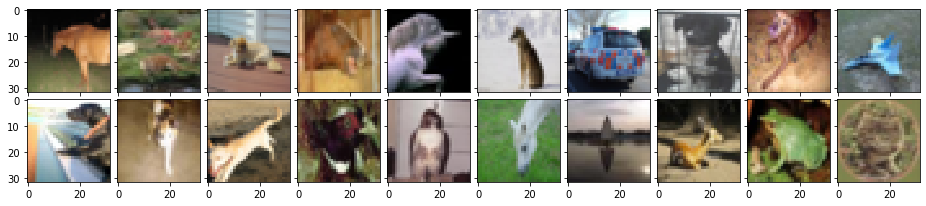

In [272]:
df_densenet_ra_3_20_errors = error_by_r_score(npzfile, test_labels_CIFAR10, test_data_CIFAR10)

In [273]:
df_densenet_ra_3_20_errors

prob_predicted  prob_correct       r_value  label_predicted_id  \
0         0.999697  2.582991e-05  3.870306e+04                   4   
1         0.988836  1.896691e-05  5.213478e+04                   4   
2         0.999949  1.889461e-05  5.292246e+04                   3   
3         0.991221  1.820815e-05  5.443830e+04                   3   
4         0.784463  1.312460e-05  5.977043e+04                   2   
5         0.695543  1.145100e-05  6.074080e+04                   2   
6         0.996016  1.368873e-05  7.276179e+04                   9   
7         0.654117  6.452447e-06  1.013751e+05                   8   
8         0.999862  9.137615e-06  1.094226e+05                   6   
9         0.999991  7.151083e-06  1.398377e+05                   2   
10        0.554010  3.766732e-06  1.470798e+05                   0   
11        0.999962  5.630297e-06  1.776038e+05                   5   
12        0.995148  5.493122e-06  1.811626e+05                   0   
13        0.997038  5.290493e-06  1.884583e+05                   6   
14        0.992995  3.101866e-06  3.201284e+05                   5   
15        0.802862  1.297050e-06  6.189909e+05                   4   
16        0.999888  1.308678e-06  7.640443e+05                   0   
17        0.999999  5.916364e-07  1.690225e+06                   0   
18        1.000000  5.051788e-07  1.979496e+06                   6   
19        0.999149  4.429299e-07  2.255774e+06                   6   

   label_predicted  correct_label correct_label_id  img_index  
0             deer              7            horse       4892  
1             deer              3              cat       4965  
2              cat              5              dog       5609  
3              cat              7            horse       6151  
4             bird              7            horse       2010  
5             bird              5              dog       6257  
6            truck              1       automobile       1131  
7             ship              5              dog       2590  
8             frog              5              dog       8428  
9             bird              0         airplane       5310  
10        airplane              5              dog       2525  
11             dog              3              cat       7099  
12        airplane              5              dog       4942  
13            frog              2             bird       8166  
14             dog              2             bird       4646  
15            deer              7            horse       4309  
16        airplane              8             ship       5548  
17        airplane              4             deer       2581  
18            frog              3              cat       2405  
19            frog              3              cat       5511

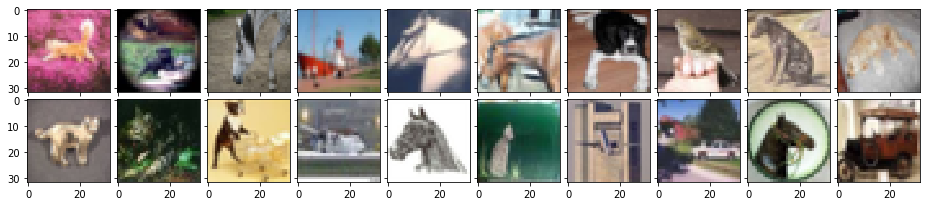

In [274]:
df_densenet_ra_3_20_errors_101  = error_by_r_score(npzfile101, test_labels_CIFAR101, test_data_CIFAR101)

In [275]:
df_densenet_ra_3_20_errors_101

prob_predicted  prob_correct       r_value  label_predicted_id  \
0         0.996307  3.179008e-04  3.134017e+03                   2   
1         0.620047  1.707050e-04  3.632269e+03                   8   
2         0.997446  2.689205e-04  3.709073e+03                   2   
3         0.985097  2.649529e-04  3.718008e+03                   0   
4         0.999758  2.159648e-04  4.629264e+03                   8   
5         0.775721  1.651032e-04  4.698398e+03                   0   
6         0.999799  2.009110e-04  4.976327e+03                   3   
7         0.829342  1.656696e-04  5.006000e+03                   3   
8         0.996825  1.797501e-04  5.545616e+03                   3   
9         0.998330  1.565231e-04  6.378163e+03                   3   
10        0.999888  1.075608e-04  9.296027e+03                   5   
11        0.999781  8.724994e-05  1.145882e+04                   6   
12        0.997951  8.341522e-05  1.196365e+04                   7   
13        0.999831  7.761025e-05  1.288272e+04                   8   
14        0.997495  1.925062e-05  5.181626e+04                   3   
15        0.999967  1.232810e-05  8.111284e+04                   2   
16        0.616344  6.282060e-06  9.811173e+04                   3   
17        0.902344  8.990524e-06  1.003661e+05                   9   
18        0.967689  1.584838e-06  6.105916e+05                   6   
19        0.999996  8.038656e-07  1.243984e+06                   9   

   label_predicted  correct_label correct_label_id  img_index  
0             bird              3              cat        733  
1             ship              5              dog       1060  
2             bird              7            horse       1414  
3         airplane              8             ship       1718  
4             ship              7            horse       1427  
5         airplane              7            horse       1406  
6              cat              5              dog       1052  
7              cat              2             bird        557  
8              cat              5              dog       1148  
9              cat              5              dog       1134  
10             dog              3              cat        664  
11            frog              3              cat        739  
12           horse              5              dog       1059  
13            ship              0         airplane        182  
14             cat              7            horse       1538  
15            bird              3              cat        611  
16             cat              0         airplane         98  
17           truck              1       automobile        365  
18            frog              7            horse       1412  
19           truck              1       automobile        391

### compare all densenet

The number of common misclassifications across all models: 3
{2405, 2525, 5511}


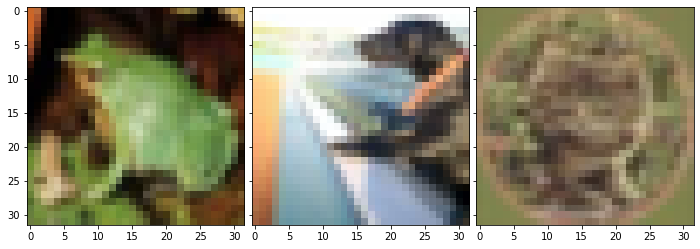

In [276]:
# View intersection of errors
#change the intersect
intersect = set(df_densenet_errors.img_index) & \
            set(df_densenet_ra_2_5_errors.img_index) & \
            set(df_densenet_ra_2_20_errors.img_index) & \
            set(df_densenet_ra_3_20_errors.img_index)

print("The number of common misclassifications across all models:", len(intersect))
print(intersect)

images_to_print = []

for i in intersect:
    img=Image.fromarray(test_data_CIFAR10[i])
    images_to_print.append(img)

# Print the misclassified images
fig = plt.figure(figsize=(16, 4))
grid = ImageGrid(fig, 111, nrows_ncols=(1, len(intersect)), axes_pad=0.1,  )

for ax, im in zip(grid, images_to_print):
    # Iterating over the grid returns the Axes.
    ax.imshow(im)

In [277]:
df = pd.DataFrame()

# change these labels

# intersect = set(df_resnet32_errors.img_index) & \
#             set(df_resnet32_errors_ra_2_5.img_index) & \
#             set(df_resnet32_errors_ra_2_20.img_index) & \
#             set(df_resnet32_errors_ra_3_20.img_index)

for m, me in [('densenet', df_densenet_errors.img_index), 
              ('densenet_ra_2_5', df_densenet_ra_2_5_errors.img_index), 
              ('densenet_ra_2_20', df_densenet_ra_2_20_errors.img_index), 
              ('densenet_ra_3_20', df_densenet_ra_3_20_errors.img_index)]:
    for e in me:
        df.loc[m, str(e)] = True
    
pd.options.display.max_rows = None
pd.options.display.max_columns = None
df.fillna(False, inplace=True)
cols = df.columns
df.reset_index(inplace=True)
df

index   5830   1969  5511   8728   1772  2525   2804   4614  \
0          densenet   True   True  True   True   True  True   True   True   
1   densenet_ra_2_5  False  False  True  False  False  True  False  False   
2  densenet_ra_2_20  False  False  True  False  False  True  False  False   
3  densenet_ra_3_20  False  False  True  False  False  True  False  False   

    4965    378   7657   2592   6151   9227   7509   9431   5548   7099  \
0   True   True   True   True   True   True   True   True   True   True   
1  False  False  False   True  False   True  False  False  False  False   
2   True   True  False  False  False   True  False  False  False  False   
3   True  False  False  False   True  False  False  False   True   True   

    6741  2405   2061   5862   9386   3957   1325     61    916   4740   4485  \
0   True  True  False  False  False  False  False  False  False  False  False   
1  False  True   True   True   True   True   True   True   True   True   True   
2  False  True  False  False  False  False  False  False  False   True  False   
3  False  True  False  False  False  False  False  False  False  False  False   

    8469   3789   1248   5417   7620   5098   8573   9840   7384   7881  \
0  False  False  False  False  False  False  False  False  False  False   
1   True   True   True   True   True   True  False  False  False  False   
2  False  False  False  False  False  False   True   True   True   True   
3  False  False  False  False  False  False  False  False  False  False   

    5908   4051   3297   2161   8778   3192    665   1935   3444   4892  \
0  False  False  False  False  False  False  False  False  False  False   
1  False  False  False  False  False  False  False  False  False  False   
2   True   True   True   True   True   True   True   True   True  False   
3  False  False  False  False  False  False  False  False  False   True   

    5609   2010   6257   1131   2590   8428   5310   4942   8166   4646  \
0  False  False  False  False  False  False  False  False  False  False   
1  False  False  False  False  False  False  False  False  False  False   
2  False  False  False  False  False  False  False  False  False  False   
3   True   True   True   True   True   True   True   True   True   True   

    4309   2581  
0  False  False  
1  False  False  
2  False  False  
3   True   True

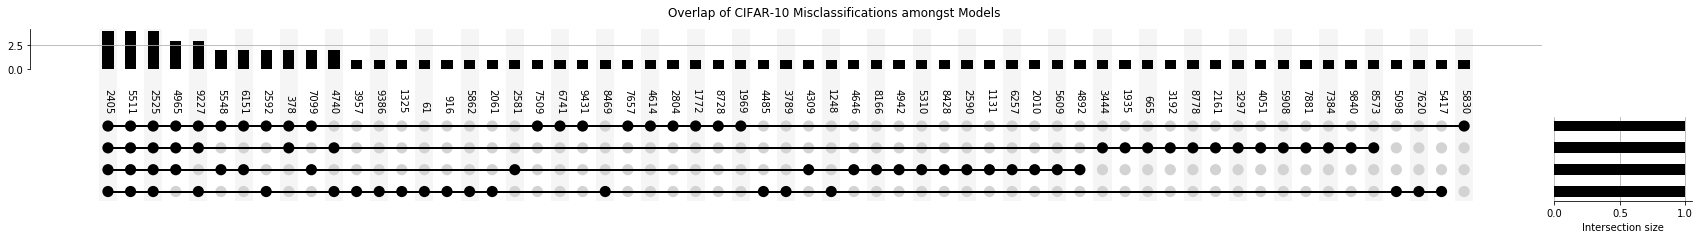

In [278]:
overlap = df.groupby(list(cols))['index'].count()

plot(overlap, orientation='vertical')  
from matplotlib import pyplot
plt.suptitle('Overlap of CIFAR-10 Misclassifications amongst Models')
pyplot.show()  

The number of common misclassifications across all models: 1
{391}


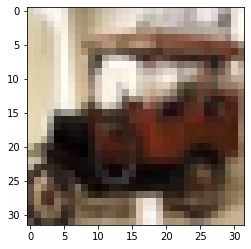

In [279]:
# View intersection of errors
intersect101 = set(df_densenet_errors_101.img_index) & \
            set(df_densenet_ra_2_5_errors_101.img_index) & \
            set(df_densenet_ra_2_20_errors_101.img_index) & \
            set(df_densenet_ra_3_20_errors_101.img_index)

            
print("The number of common misclassifications across all models:", len(intersect101))
print(intersect101)

# View errors 
# df_errors_101 = pd.DataFrame({'resnext_29_4x64' : df_resnext4_errors_101.img_index,
#                              'resnext_29_8x64' : df_resnext8_errors_101.img_index,
#                              'resnet32' : df_resnet32_errors_101.img_index,
#                              'densenet' : df_densenet_errors_101.img_index,
#                              'wrn_28_10' : df_wrn_28_10_errors_101.img_index,
#                              'pyramidnet_basic_110_84' : df_pyramidnet_basic_110_84_errors_101.img_index,
#                              'resnet44' : df_resnet44_errors.img_index})

images_to_print = []

for i in intersect101:
    img=Image.fromarray(test_data_CIFAR101[i])
    images_to_print.append(img)

# Print the misclassified images
fig = plt.figure(figsize=(16, 4))
grid = ImageGrid(fig, 111, nrows_ncols=(1, len(intersect101)), axes_pad=0.1,  )

for ax, im in zip(grid, images_to_print):
    # Iterating over the grid returns the Axes.
    ax.imshow(im)

In [280]:
df101 = pd.DataFrame()

for m, me in [('densenet', df_densenet_errors_101.img_index), 
              ('densenet_ra_2_5', df_densenet_ra_2_5_errors_101.img_index), 
              ('densenet_ra_2_20', df_densenet_ra_2_20_errors_101.img_index), 
              ('densenet_ra_3_20', df_densenet_ra_3_20_errors_101.img_index)]:
    for e in me:
        df101.loc[m, str(e)] = True
    
pd.options.display.max_rows = None
pd.options.display.max_columns = None
df101.fillna(False, inplace=True)
cols = df101.columns
df101.reset_index(inplace=True)
df101

index    365     76   1126    772   1753   1060    592    600  \
0          densenet   True   True   True   True   True   True   True   True   
1   densenet_ra_2_5  False  False   True   True  False   True  False  False   
2  densenet_ra_2_20  False  False  False   True  False  False  False  False   
3  densenet_ra_3_20   True  False  False  False  False   True  False  False   

     996    671    420   1076    783   1134    602   1148    433    254   391  \
0   True   True   True   True   True   True   True   True   True   True  True   
1   True  False  False   True  False  False  False  False  False  False  True   
2  False  False   True   True  False   True  False  False  False  False  True   
3  False  False  False  False  False   True  False   True  False  False  True   

     336    977    571    668    757   1426    382    309   1412    528  \
0   True  False  False  False  False  False  False  False  False  False   
1   True   True   True   True   True   True   True   True   True   True   
2  False  False  False  False   True  False  False  False   True  False   
3  False  False  False  False  False  False  False  False   True  False   

    1414    167   1117   1623   1973    837    910    482   1121   1072  \
0  False  False  False  False  False  False  False  False  False  False   
1   True   True   True   True  False  False  False  False  False  False   
2  False  False  False  False   True   True   True   True   True   True   
3   True  False  False  False  False  False  False  False  False  False   

       7   1139    381    426   1045    471   1164    733   1718   1427  \
0  False  False  False  False  False  False  False  False  False  False   
1  False  False  False  False  False  False  False  False  False  False   
2   True   True   True   True   True   True   True  False  False  False   
3  False  False  False  False  False  False  False   True   True   True   

    1406   1052    557    664    739   1059    182   1538    611     98  
0  False  False  False  False  False  False  False  False  False  False  
1  False  False  False  False  False  False  False  False  False  False  
2  False  False  False  False  False  False  False  False  False  False  
3   True   True   True   True   True   True   True   True   True   True

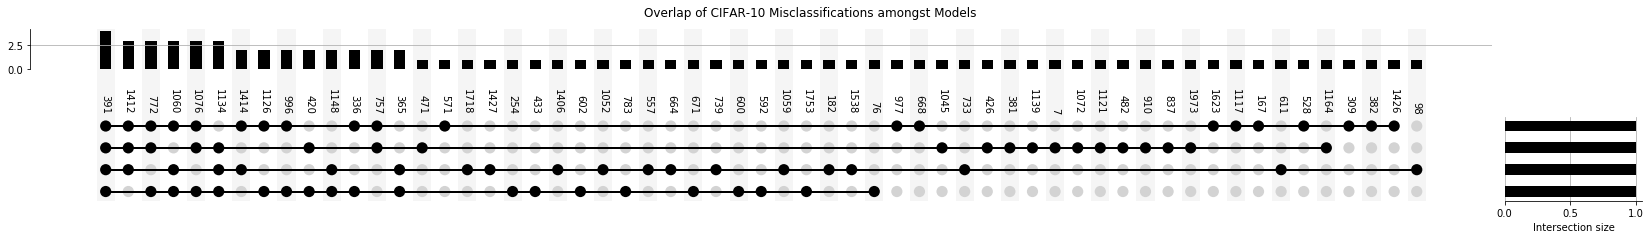

In [281]:
overlap = df101.groupby(list(cols))['index'].count()

plot(overlap, orientation='vertical')  
from matplotlib import pyplot
plt.suptitle('Overlap of CIFAR-10 Misclassifications amongst Models')
pyplot.show() 

# resnext section

### resnext, no RA

In [282]:
output = './resnext_29_4x64/predictions_300.npz'
npzfile = np.load(output)
confirm_score(npzfile, test_labels_CIFAR10)


Accuracy: 0.9535
 -> Sanity Check: 9535 of 10000 correct

              precision  recall  f1-score     support
0 airplane     0.960080  0.9620  0.961039   1000.0000
1 automobile   0.980981  0.9800  0.980490   1000.0000
2 bird         0.944779  0.9410  0.942886   1000.0000
3 cat          0.892108  0.8930  0.892554   1000.0000
4  deer        0.942495  0.9670  0.954590   1000.0000
5 dog          0.930612  0.9120  0.921212   1000.0000
6 frog         0.963257  0.9700  0.966617   1000.0000
7 horse        0.983707  0.9660  0.974773   1000.0000
8 ship         0.970090  0.9730  0.971543   1000.0000
9 truck        0.967131  0.9710  0.969062   1000.0000
accuracy       0.953500  0.9535  0.953500      0.9535
macro avg      0.953524  0.9535  0.953477  10000.0000
weighted avg   0.953524  0.9535  0.953477  10000.0000


In [283]:
output = './resnext_29_4x64/predictions_300_CIFAR101.npz'
npzfile101 = np.load(output)
confirm_score(npzfile101, test_labels_CIFAR101)


Accuracy: 0.8905
 -> Sanity Check: 0 of 2000 correct

              precision  recall  f1-score    support
0 airplane     0.908602  0.8450  0.875648   200.0000
1 automobile   0.958824  0.8150  0.881081   200.0000
2 bird         0.888350  0.9150  0.901478   200.0000
3 cat          0.827225  0.7900  0.808184   200.0000
4  deer        0.892523  0.9550  0.922705   200.0000
5 dog          0.874346  0.8350  0.854220   200.0000
6 frog         0.921951  0.9450  0.933333   200.0000
7 horse        0.924623  0.9200  0.922306   200.0000
8 ship         0.900000  0.9450  0.921951   200.0000
9 truck        0.824561  0.9400  0.878505   200.0000
accuracy       0.890500  0.8905  0.890500     0.8905
macro avg      0.892100  0.8905  0.889941  2000.0000
weighted avg   0.892100  0.8905  0.889941  2000.0000


/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/ipykernel/__main__.py:30: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


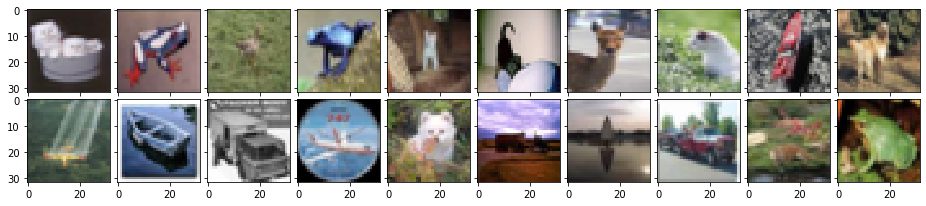

In [284]:
df_resnext_errors = error_by_r_score(npzfile, test_labels_CIFAR10, test_data_CIFAR10)

In [285]:
df_resnext_errors

prob_predicted  prob_correct        r_value  label_predicted_id  \
0         0.992864      0.000906    1095.530884                   8   
1         0.995250      0.000898    1107.953735                   0   
2         0.999062      0.000896    1115.018677                   4   
3         0.918964      0.000820    1121.106445                   2   
4         0.986606      0.000761    1295.803101                   3   
5         0.997638      0.000767    1300.490723                   2   
6         0.999297      0.000466    2145.291992                   5   
7         0.987027      0.000440    2243.779785                   2   
8         0.993101      0.000407    2437.718018                   2   
9         0.998823      0.000322    3097.743408                   4   
10        0.999315      0.000308    3246.277588                   8   
11        0.999624      0.000255    3916.698730                   1   
12        0.999411      0.000218    4579.142090                   1   
13        0.996964      0.000155    6434.504883                   8   
14        0.999611      0.000138    7238.125000                   3   
15        0.999634      0.000119    8391.208008                   0   
16        0.999817      0.000087   11441.147461                   0   
17        0.999959      0.000026   37883.054688                   9   
18        0.999969      0.000004  262986.093750                   4   
19        0.999805      0.000003  387136.750000                   6   

   label_predicted  correct_label correct_label_id  img_index  
0             ship              3              cat       9812  
1         airplane              6             frog       4744  
2             deer              2             bird       1325  
3             bird              6             frog       3615  
4              cat              5              dog       4740  
5             bird              5              dog        810  
6              dog              4             deer       1217  
7             bird              3              cat       3052  
8             bird              8             ship       1685  
9             deer              5              dog       4528  
10            ship              0         airplane        378  
11      automobile              8             ship       7559  
12      automobile              9            truck       5455  
13            ship              0         airplane       8743  
14             cat              5              dog       4275  
15        airplane              9            truck       3957  
16        airplane              8             ship       5548  
17           truck              1       automobile       9227  
18            deer              3              cat       4965  
19            frog              3              cat       2405

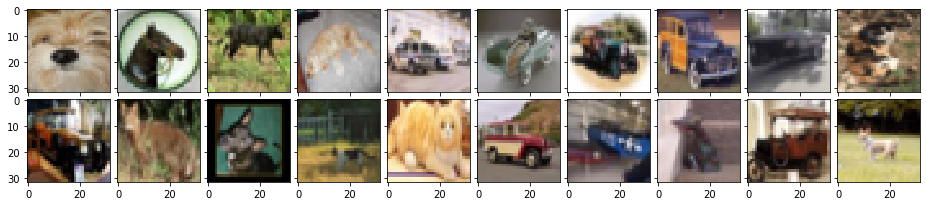

In [286]:
df_resnext_errors_101  = error_by_r_score(npzfile101, test_labels_CIFAR101, test_data_CIFAR101)

In [287]:
df_resnext_errors_101

prob_predicted  prob_correct       r_value  label_predicted_id  \
0         0.996358      0.002389    417.090912                   3   
1         0.887847      0.001992    445.627350                   6   
2         0.868874      0.001934    449.283966                   7   
3         0.995478      0.002200    452.404816                   3   
4         0.996879      0.002081    478.928467                   9   
5         0.994601      0.002016    493.451080                   6   
6         0.997193      0.001984    502.681061                   9   
7         0.998023      0.001683    593.072083                   9   
8         0.847274      0.001398    605.875488                   1   
9         0.995697      0.001643    606.004333                   5   
10        0.978815      0.001334    733.907898                   9   
11        0.987949      0.001264    781.673096                   4   
12        0.998764      0.001169    854.702881                   3   
13        0.986349      0.000486   2029.805908                   4   
14        0.999390      0.000351   2848.285156                   5   
15        0.999462      0.000301   3321.299561                   9   
16        0.999135      0.000232   4311.464355                   8   
17        0.998629      0.000158   6321.289551                   4   
18        0.996014      0.000157   6352.357910                   9   
19        0.999844      0.000012  81720.085938                   4   

   label_predicted  correct_label correct_label_id  img_index  
0              cat              5              dog       1035  
1             frog              7            horse       1412  
2            horse              3              cat        743  
3              cat              5              dog       1134  
4            truck              1       automobile        368  
5             frog              1       automobile        351  
6            truck              1       automobile        342  
7            truck              1       automobile        378  
8       automobile              8             ship       1623  
9              dog              3              cat        783  
10           truck              1       automobile        344  
11            deer              3              cat        668  
12             cat              5              dog       1126  
13            deer              3              cat        772  
14             dog              3              cat        602  
15           truck              1       automobile        254  
16            ship              0         airplane        131  
17            deer              3              cat        792  
18           truck              1       automobile        391  
19            deer              5              dog       1076

### resnext, RA(2,5)

In [289]:
output = './resnext_29_4x64d_ra_2_5/predictions_400_refined50.npz'
npzfile = np.load(output)
confirm_score(npzfile, test_labels_CIFAR10)


Accuracy: 0.9403
 -> Sanity Check: 9403 of 10000 correct

              precision  recall  f1-score     support
0 airplane     0.941061  0.9580  0.949455   1000.0000
1 automobile   0.978894  0.9740  0.976441   1000.0000
2 bird         0.946429  0.9010  0.923156   1000.0000
3 cat          0.869960  0.8630  0.866466   1000.0000
4  deer        0.935294  0.9540  0.944554   1000.0000
5 dog          0.885035  0.8930  0.889000   1000.0000
6 frog         0.944063  0.9620  0.952947   1000.0000
7 horse        0.972837  0.9670  0.969910   1000.0000
8 ship         0.955709  0.9710  0.963294   1000.0000
9 truck        0.974619  0.9600  0.967254   1000.0000
accuracy       0.940300  0.9403  0.940300      0.9403
macro avg      0.940390  0.9403  0.940248  10000.0000
weighted avg   0.940390  0.9403  0.940248  10000.0000


In [291]:
output = './resnext_29_4x64d_ra_2_5/predictions_400_refined50_cifar101.npz'
npzfile101 = np.load(output)
confirm_score(npzfile101, test_labels_CIFAR101)


Accuracy: 0.8455
 -> Sanity Check: 0 of 2000 correct

              precision  recall  f1-score    support
0 airplane     0.849162  0.7600  0.802111   200.0000
1 automobile   0.950311  0.7650  0.847645   200.0000
2 bird         0.855670  0.8300  0.842640   200.0000
3 cat          0.752427  0.7750  0.763547   200.0000
4  deer        0.837321  0.8750  0.855746   200.0000
5 dog          0.834197  0.8050  0.819338   200.0000
6 frog         0.859903  0.8900  0.874693   200.0000
7 horse        0.897959  0.8800  0.888889   200.0000
8 ship         0.873239  0.9300  0.900726   200.0000
9 truck        0.780992  0.9450  0.855204   200.0000
accuracy       0.845500  0.8455  0.845500     0.8455
macro avg      0.849118  0.8455  0.845054  2000.0000
weighted avg   0.849118  0.8455  0.845054  2000.0000


/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/ipykernel/__main__.py:30: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


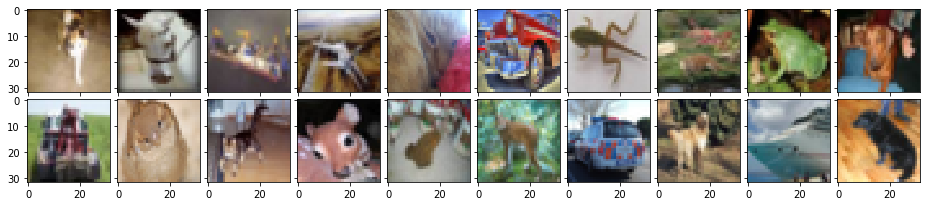

In [292]:
df_resnext_ra_2_5_errors = error_by_r_score(npzfile, test_labels_CIFAR10, test_data_CIFAR10)

In [293]:
df_resnext_ra_2_5_errors

prob_predicted  prob_correct       r_value  label_predicted_id  \
0         0.999435      0.000123   8112.354004                   5   
1         0.999335      0.000108   9229.202148                   5   
2         0.999107      0.000108   9265.864258                   6   
3         0.999546      0.000099  10141.971680                   4   
4         0.999422      0.000096  10436.019531                   4   
5         0.999766      0.000088  11321.538086                   9   
6         0.998814      0.000087  11443.451172                   0   
7         0.999244      0.000087  11486.103516                   4   
8         0.999167      0.000084  11829.608398                   6   
9         0.999664      0.000080  12511.045898                   3   
10        0.999554      0.000078  12789.964844                   8   
11        0.999413      0.000072  13879.416016                   3   
12        0.999396      0.000064  15719.822266                   7   
13        0.999614      0.000061  16346.745117                   3   
14        0.999774      0.000060  16598.058594                   3   
15        0.999578      0.000055  18159.353516                   5   
16        0.999750      0.000043  23277.033203                   9   
17        0.999690      0.000041  24105.417969                   4   
18        0.999886      0.000035  28231.826172                   0   
19        0.999923      0.000032  31266.000000                   3   

   label_predicted  correct_label correct_label_id  img_index  
0              dog              3              cat       7099  
1              dog              7            horse       2895  
2             frog              8             ship       5398  
3             deer              0         airplane       3097  
4             deer              3              cat        916  
5            truck              1       automobile       7892  
6         airplane              6             frog       8573  
7             deer              3              cat       4965  
8             frog              3              cat       2405  
9              cat              5              dog       8410  
10            ship              9            truck        213  
11             cat              2             bird       7761  
12           horse              3              cat       4485  
13             cat              4             deer       4112  
14             cat              6             frog         59  
15             dog              4             deer       8354  
16           truck              1       automobile       1131  
17            deer              5              dog       4528  
18        airplane              8             ship        665  
19             cat              5              dog       3236

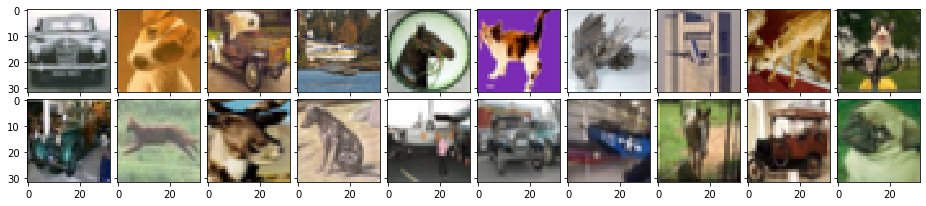

In [294]:
df_resnext_ra_2_5_errors_101  = error_by_r_score(npzfile101, test_labels_CIFAR101, test_data_CIFAR101)

In [295]:
df_resnext_ra_2_5_errors_101

prob_predicted  prob_correct       r_value  label_predicted_id  \
0         0.989009      0.001734    570.290894                   9   
1         0.991720      0.001712    579.170349                   3   
2         0.997831      0.001693    589.532410                   9   
3         0.979016      0.001634    599.144958                   8   
4         0.551262      0.000857    643.412354                   3   
5         0.996038      0.001451    686.595215                   5   
6         0.810740      0.001179    687.881165                   6   
7         0.962519      0.001367    703.855408                   3   
8         0.928624      0.001312    707.739136                   3   
9         0.649154      0.000871    745.641174                   7   
10        0.997557      0.000948   1052.010010                   9   
11        0.747652      0.000529   1413.067383                   4   
12        0.998150      0.000505   1977.813965                   5   
13        0.991432      0.000255   3881.241211                   3   
14        0.998568      0.000236   4225.872070                   9   
15        0.999705      0.000196   5103.888184                   9   
16        0.999715      0.000066  15069.614258                   8   
17        0.999875      0.000064  15645.773438                   4   
18        0.999499      0.000060  16612.121094                   9   
19        0.999921      0.000020  48821.269531                   6   

   label_predicted  correct_label correct_label_id  img_index  
0            truck              1       automobile        337  
1              cat              5              dog       1139  
2            truck              1       automobile        336  
3             ship              0         airplane        187  
4              cat              7            horse       1412  
5              dog              3              cat        766  
6             frog              2             bird        433  
7              cat              0         airplane         98  
8              cat              4             deer        910  
9            horse              3              cat        706  
10           truck              1       automobile        345  
11            deer              3              cat        671  
12             dog              4             deer        996  
13             cat              5              dog       1148  
14           truck              0         airplane        167  
15           truck              1       automobile        277  
16            ship              0         airplane        131  
17            deer              7            horse       1596  
18           truck              1       automobile        391  
19            frog              5              dog       1102

### resnext, RA(2,20)

In [306]:
output = './resnext_29_4x64_ra_2_20/ predictions_400_refined50.npz'
npzfile = np.load(output)
confirm_score(npzfile, test_labels_CIFAR10)


Accuracy: 0.926
 -> Sanity Check: 9260 of 10000 correct

              precision  recall  f1-score    support
0 airplane     0.928780   0.952  0.940247   1000.000
1 automobile   0.963184   0.968  0.965586   1000.000
2 bird         0.918135   0.886  0.901781   1000.000
3 cat          0.823242   0.843  0.833004   1000.000
4  deer        0.923838   0.934  0.928891   1000.000
5 dog          0.873000   0.873  0.873000   1000.000
6 frog         0.957187   0.939  0.948006   1000.000
7 horse        0.957447   0.945  0.951183   1000.000
8 ship         0.962076   0.964  0.963037   1000.000
9 truck        0.956000   0.956  0.956000   1000.000
accuracy       0.926000   0.926  0.926000      0.926
macro avg      0.926289   0.926  0.926073  10000.000
weighted avg   0.926289   0.926  0.926073  10000.000


In [308]:
output = './resnext_29_4x64_ra_2_20/ predictions_400_refined50_CIFAR101.npz'
npzfile101 = np.load(output)
confirm_score(npzfile101, test_labels_CIFAR101)


Accuracy: 0.8505
 -> Sanity Check: 0 of 2000 correct

              precision  recall  f1-score    support
0 airplane     0.857895  0.8150  0.835897   200.0000
1 automobile   0.940476  0.7900  0.858696   200.0000
2 bird         0.829897  0.8050  0.817259   200.0000
3 cat          0.731343  0.7350  0.733167   200.0000
4  deer        0.862069  0.8750  0.868486   200.0000
5 dog          0.837438  0.8500  0.843672   200.0000
6 frog         0.866029  0.9050  0.885086   200.0000
7 horse        0.909091  0.9000  0.904523   200.0000
8 ship         0.862559  0.9100  0.885645   200.0000
9 truck        0.825112  0.9200  0.869976   200.0000
accuracy       0.850500  0.8505  0.850500     0.8505
macro avg      0.852191  0.8505  0.850241  2000.0000
weighted avg   0.852191  0.8505  0.850241  2000.0000


/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/ipykernel/__main__.py:30: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


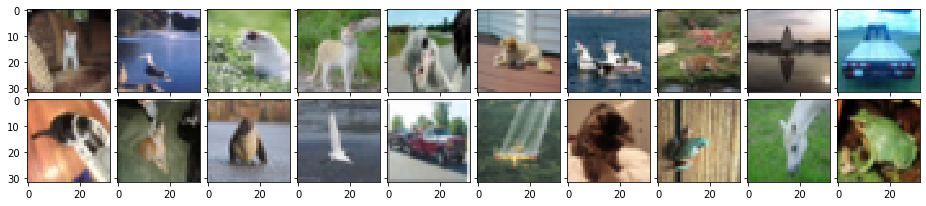

In [309]:
df_resnext_ra_2_20_errors = error_by_r_score(npzfile, test_labels_CIFAR10, test_data_CIFAR10)

In [310]:
df_resnext_ra_2_20_errors

prob_predicted  prob_correct       r_value  label_predicted_id  \
0         0.990551      0.000290   3418.963135                   3   
1         0.988416      0.000239   4138.235840                   0   
2         0.989053      0.000214   4627.163086                   2   
3         0.773523      0.000142   5446.745605                   5   
4         0.980300      0.000171   5734.778809                   5   
5         0.999792      0.000174   5762.140625                   3   
6         0.999840      0.000143   6983.882324                   8   
7         0.994929      0.000134   7450.174805                   4   
8         0.999477      0.000131   7636.610352                   0   
9         0.977683      0.000124   7899.464844                   1   
10        0.999879      0.000111   8968.184570                   5   
11        0.998830      0.000107   9303.256836                   4   
12        0.995517      0.000090  11039.358398                   3   
13        0.999866      0.000082  12173.824219                   8   
14        0.999928      0.000047  21260.095703                   9   
15        0.999705      0.000045  22346.271484                   8   
16        0.999967      0.000024  42241.496094                   5   
17        0.996401      0.000022  46248.402344                   2   
18        0.993547      0.000021  48457.601562                   5   
19        0.999971      0.000017  58993.511719                   6   

   label_predicted  correct_label correct_label_id  img_index  
0              cat              5              dog       4740  
1         airplane              2             bird        725  
2             bird              3              cat       3052  
3              dog              3              cat       8983  
4              dog              2             bird       7657  
5              cat              5              dog       5609  
6             ship              0         airplane       4784  
7             deer              3              cat       4965  
8         airplane              8             ship       5548  
9       automobile              9            truck       4931  
10             dog              3              cat       9819  
11            deer              3              cat        470  
12             cat              2             bird       9704  
13            ship              2             bird       7000  
14           truck              1       automobile       9227  
15            ship              0         airplane        378  
16             dog              3              cat        811  
17            bird              6             frog       1935  
18             dog              7            horse       4309  
19            frog              3              cat       2405

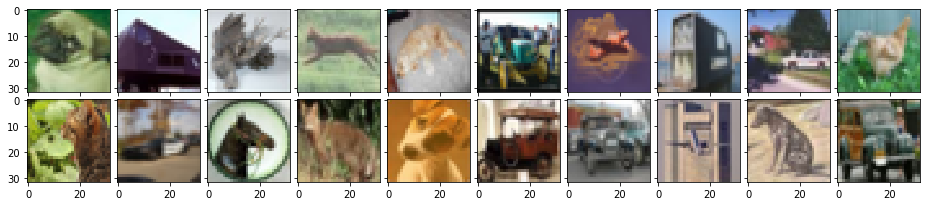

In [311]:
df_resnext_ra_2_20_errors_101  = error_by_r_score(npzfile101, test_labels_CIFAR101, test_data_CIFAR101)

In [312]:
df_resnext_ra_2_20_errors_101

prob_predicted  prob_correct       r_value  label_predicted_id  \
0         0.874553      0.001237    706.913513                   6   
1         0.998234      0.001350    739.317261                   9   
2         0.836920      0.000933    897.292358                   0   
3         0.984808      0.001069    921.593994                   4   
4         0.997333      0.000966   1031.910400                   3   
5         0.994435      0.000882   1127.534424                   9   
6         0.998662      0.000764   1307.222778                   6   
7         0.993930      0.000705   1409.640625                   9   
8         0.996758      0.000537   1854.656982                   0   
9         0.995257      0.000454   2189.894043                   3   
10        0.999057      0.000432   2312.093750                   6   
11        0.996576      0.000326   3058.747314                   9   
12        0.989898      0.000250   3966.803955                   3   
13        0.992762      0.000155   6417.908691                   4   
14        0.999864      0.000117   8544.225586                   3   
15        0.999595      0.000068  14734.529297                   9   
16        0.999926      0.000067  15032.166016                   9   
17        0.995943      0.000057  17328.156250                   3   
18        0.999877      0.000040  24911.720703                   3   
19        0.999949      0.000034  29507.800781                   9   

   label_predicted  correct_label correct_label_id  img_index  
0             frog              5              dog       1102  
1            truck              0         airplane         12  
2         airplane              2             bird        433  
3             deer              3              cat        671  
4              cat              5              dog       1134  
5            truck              1       automobile        379  
6             frog              0         airplane        102  
7            truck              8             ship       1761  
8         airplane              1       automobile        365  
9              cat              2             bird        592  
10            frog              3              cat        605  
11           truck              1       automobile        369  
12             cat              7            horse       1412  
13            deer              3              cat        668  
14             cat              5              dog       1139  
15           truck              1       automobile        391  
16           truck              1       automobile        277  
17             cat              0         airplane         98  
18             cat              5              dog       1148  
19           truck              1       automobile        392

### resnext, RA(3,20)

In [313]:
output = './resnext_29_4x64_ra_3_20/ predictions_400_refined50.npz'
npzfile = np.load(output)
confirm_score(npzfile, test_labels_CIFAR10)


Accuracy: 0.9018
 -> Sanity Check: 9018 of 10000 correct

              precision  recall  f1-score     support
0 airplane     0.903960  0.9130  0.908458   1000.0000
1 automobile   0.958918  0.9570  0.957958   1000.0000
2 bird         0.890593  0.8710  0.880688   1000.0000
3 cat          0.818374  0.7750  0.796097   1000.0000
4  deer        0.871498  0.9020  0.886486   1000.0000
5 dog          0.821083  0.8490  0.834808   1000.0000
6 frog         0.940060  0.9410  0.940530   1000.0000
7 horse        0.938713  0.9190  0.928752   1000.0000
8 ship         0.929057  0.9560  0.942336   1000.0000
9 truck        0.945399  0.9350  0.940171   1000.0000
accuracy       0.901800  0.9018  0.901800      0.9018
macro avg      0.901766  0.9018  0.901628  10000.0000
weighted avg   0.901766  0.9018  0.901628  10000.0000


In [314]:
output = './resnext_29_4x64_ra_3_20/ predictions_400_refined50_cifar101.npz'
npzfile101 = np.load(output)
confirm_score(npzfile101, test_labels_CIFAR101)


Accuracy: 0.8185
 -> Sanity Check: 0 of 2000 correct

              precision  recall  f1-score    support
0 airplane     0.848649  0.7850  0.815584   200.0000
1 automobile   0.904192  0.7550  0.822888   200.0000
2 bird         0.867403  0.7850  0.824147   200.0000
3 cat          0.724868  0.6850  0.704370   200.0000
4  deer        0.754386  0.8600  0.803738   200.0000
5 dog          0.785366  0.8050  0.795062   200.0000
6 frog         0.830097  0.8550  0.842365   200.0000
7 horse        0.856436  0.8650  0.860697   200.0000
8 ship         0.832558  0.8950  0.862651   200.0000
9 truck        0.806306  0.8950  0.848341   200.0000
accuracy       0.818500  0.8185  0.818500     0.8185
macro avg      0.821026  0.8185  0.817984  2000.0000
weighted avg   0.821026  0.8185  0.817984  2000.0000


/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/ipykernel/__main__.py:30: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


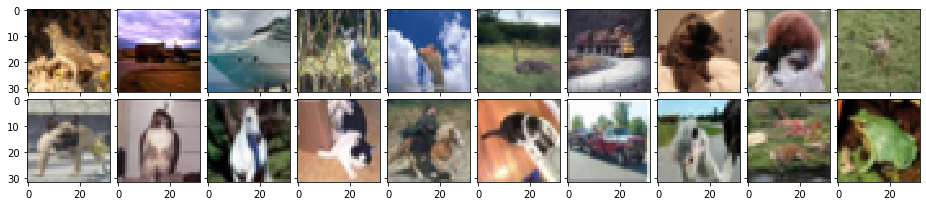

In [315]:
df_resnext_ra_3_20_errors = error_by_r_score(npzfile, test_labels_CIFAR10, test_data_CIFAR10)

In [316]:
df_resnext_ra_3_20_errors

prob_predicted  prob_correct       r_value  label_predicted_id  \
0         0.985311  1.751478e-04  5.625596e+03                   6   
1         0.991030  1.760126e-04  5.630449e+03                   0   
2         0.999820  1.700428e-04  5.879814e+03                   0   
3         0.999503  1.474530e-04  6.778450e+03                   4   
4         0.970401  1.428921e-04  6.791145e+03                   3   
5         0.999828  1.331327e-04  7.510010e+03                   4   
6         0.998782  1.327545e-04  7.523523e+03                   8   
7         0.999639  9.354817e-05  1.068583e+04                   5   
8         0.999761  8.376101e-05  1.193588e+04                   5   
9         0.999751  6.128438e-05  1.631331e+04                   4   
10        0.996651  5.948779e-05  1.675388e+04                   5   
11        0.947862  5.217541e-05  1.816684e+04                   5   
12        0.989989  3.323390e-05  2.978854e+04                   3   
13        0.999925  2.207750e-05  4.529159e+04                   5   
14        0.999743  2.127661e-05  4.698787e+04                   5   
15        0.999983  1.248387e-05  8.010205e+04                   5   
16        0.999987  1.009220e-05  9.908512e+04                   9   
17        0.985757  6.661868e-06  1.479701e+05                   5   
18        0.999996  9.011981e-07  1.109629e+06                   4   
19        0.999999  4.229743e-08  2.364208e+07                   6   

   label_predicted  correct_label correct_label_id  img_index  
0             frog              2             bird       9982  
1         airplane              9            truck       3957  
2         airplane              8             ship        665  
3             deer              2             bird       9503  
4              cat              2             bird       2165  
5             deer              2             bird       3658  
6             ship              9            truck       2495  
7              dog              3              cat        811  
8              dog              2             bird       4302  
9             deer              2             bird       1325  
10             dog              3              cat       2804  
11             dog              2             bird       4646  
12             cat              7            horse       1040  
13             dog              3              cat       3867  
14             dog              7            horse       1884  
15             dog              3              cat       9819  
16           truck              1       automobile       9227  
17             dog              2             bird       7657  
18            deer              3              cat       4965  
19            frog              3              cat       2405

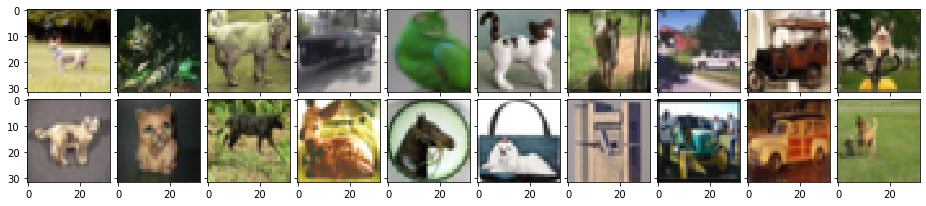

In [317]:
df_resnext_ra_3_20_errors_101  = error_by_r_score(npzfile101, test_labels_CIFAR101, test_data_CIFAR101)

In [318]:
df_resnext_ra_3_20_errors_101

prob_predicted  prob_correct       r_value  label_predicted_id  \
0         0.880981      0.000900    979.176208                   4   
1         0.991158      0.001005    985.847046                   6   
2         0.648819      0.000639   1015.897827                   4   
3         0.988721      0.000897   1102.756348                   9   
4         0.998073      0.000568   1758.246948                   6   
5         0.999228      0.000535   1867.493652                   5   
6         0.995825      0.000477   2087.104248                   4   
7         0.988611      0.000448   2205.504150                   0   
8         0.996951      0.000392   2544.103516                   9   
9         0.998134      0.000378   2639.715820                   7   
10        0.991605      0.000339   2928.035889                   5   
11        0.999662      0.000328   3050.043701                   5   
12        0.986101      0.000287   3441.673340                   4   
13        0.986644      0.000199   4949.311523                   6   
14        0.963617      0.000182   5284.506836                   3   
15        0.999449      0.000109   9175.082031                   2   
16        0.983114      0.000085  11551.894531                   3   
17        0.999102      0.000080  12535.183594                   9   
18        0.999921      0.000070  14224.909180                   9   
19        0.999874      0.000046  21517.703125                   4   

   label_predicted  correct_label correct_label_id  img_index  
0             deer              5              dog       1076  
1             frog              3              cat        739  
2             deer              3              cat        641  
3            truck              8             ship       1623  
4             frog              2             bird        427  
5              dog              3              cat        600  
6             deer              7            horse       1596  
7         airplane              1       automobile        365  
8            truck              1       automobile        391  
9            horse              3              cat        706  
10             dog              3              cat        664  
11             dog              3              cat        757  
12            deer              3              cat        743  
13            frog              4             deer        861  
14             cat              7            horse       1412  
15            bird              5              dog       1039  
16             cat              0         airplane         98  
17           truck              1       automobile        379  
18           truck              1       automobile        390  
19            deer              5              dog       1162

### comparison of missed images

The number of common misclassifications across all models: 2
{2405, 4965}


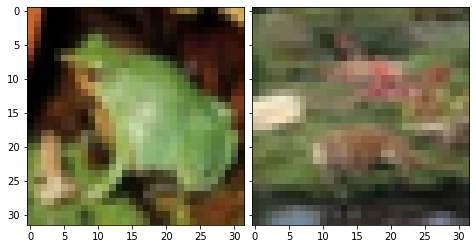

In [319]:
# View intersection of errors
#change the intersect
intersect = set(df_resnext_errors.img_index) & \
            set(df_resnext_ra_2_5_errors.img_index) & \
            set(df_resnext_ra_2_20_errors.img_index) & \
            set(df_resnext_ra_3_20_errors.img_index)

print("The number of common misclassifications across all models:", len(intersect))
print(intersect)
images_to_print = []
for i in intersect:
    img=Image.fromarray(test_data_CIFAR10[i])
    images_to_print.append(img)

# Print the misclassified images
fig = plt.figure(figsize=(16, 4))
grid = ImageGrid(fig, 111, nrows_ncols=(1, len(intersect)), axes_pad=0.1,  )
for ax, im in zip(grid, images_to_print):
    # Iterating over the grid returns the Axes.
    ax.imshow(im)

In [320]:
df = pd.DataFrame()

# change these labels

# intersect = set(df_resnet32_errors.img_index) & \
#             set(df_resnet32_errors_ra_2_5.img_index) & \
#             set(df_resnet32_errors_ra_2_20.img_index) & \
#             set(df_resnet32_errors_ra_3_20.img_index)

for m, me in [('resnext', df_resnext_errors.img_index), 
              ('resnext_ra_2_5', df_resnext_ra_2_5_errors.img_index), 
              ('resnext_ra_2_20', df_resnext_ra_2_20_errors.img_index), 
              ('resnext_ra_3_20', df_resnext_ra_3_20_errors.img_index)]:
    for e in me:
        df.loc[m, str(e)] = True
    
pd.options.display.max_rows = None
pd.options.display.max_columns = None
df.fillna(False, inplace=True)
cols = df.columns
df.reset_index(inplace=True)
df

index   9812   4744   1325   3615   4740    810   1217   3052  \
0          resnext   True   True   True   True   True   True   True   True   
1   resnext_ra_2_5  False  False  False  False  False  False  False  False   
2  resnext_ra_2_20  False  False  False  False   True  False  False   True   
3  resnext_ra_3_20  False  False   True  False  False  False  False  False   

    1685   4528    378   7559   5455   8743   4275   3957   5548   9227  4965  \
0   True   True   True   True   True   True   True   True   True   True  True   
1  False   True  False  False  False  False  False  False  False  False  True   
2  False  False   True  False  False  False  False  False   True   True  True   
3  False  False  False  False  False  False  False   True  False   True  True   

   2405   7099   2895   5398   3097    916   7892   8573   8410    213   7761  \
0  True  False  False  False  False  False  False  False  False  False  False   
1  True   True   True   True   True   True   True   True   True   True   True   
2  True  False  False  False  False  False  False  False  False  False  False   
3  True  False  False  False  False  False  False  False  False  False  False   

    4485   4112     59   8354   1131    665   3236    725   8983   7657  \
0  False  False  False  False  False  False  False  False  False  False   
1   True   True   True   True   True   True   True  False  False  False   
2  False  False  False  False  False  False  False   True   True   True   
3  False  False  False  False  False   True  False  False  False   True   

    5609   4784   4931   9819    470   9704   7000    811   1935   4309  \
0  False  False  False  False  False  False  False  False  False  False   
1  False  False  False  False  False  False  False  False  False  False   
2   True   True   True   True   True   True   True   True   True   True   
3  False  False  False   True  False  False  False   True  False  False   

    9982   9503   2165   3658   2495   4302   2804   4646   1040   3867   1884  
0  False  False  False  False  False  False  False  False  False  False  False  
1  False  False  False  False  False  False  False  False  False  False  False  
2  False  False  False  False  False  False  False  False  False  False  False  
3   True   True   True   True   True   True   True   True   True   True   True

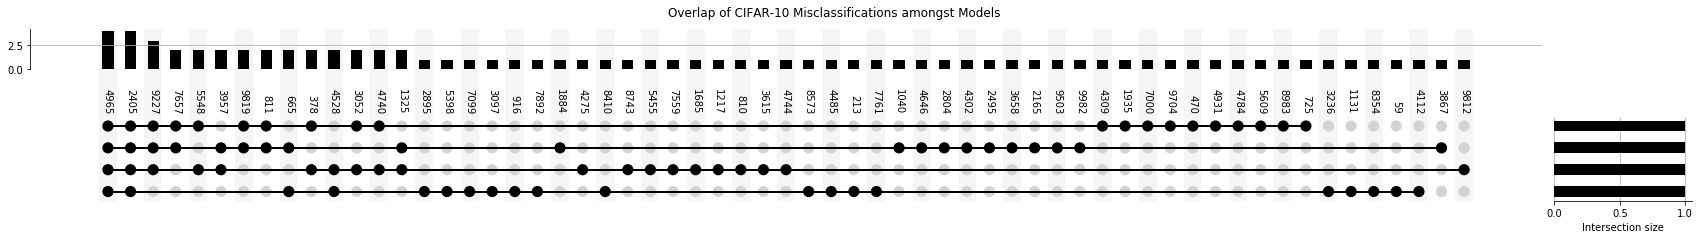

In [321]:
overlap = df.groupby(list(cols))['index'].count()

plot(overlap, orientation='vertical')  
from matplotlib import pyplot
plt.suptitle('Overlap of CIFAR-10 Misclassifications amongst Models')
pyplot.show()  

The number of common misclassifications across all models: 2
{1412, 391}


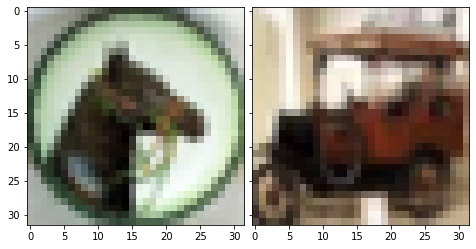

In [322]:
# View intersection of errors
intersect101 = set(df_resnext_errors_101.img_index) & \
            set(df_resnext_ra_2_5_errors_101.img_index) & \
            set(df_resnext_ra_2_20_errors_101.img_index) & \
            set(df_resnext_ra_3_20_errors_101.img_index)

            
print("The number of common misclassifications across all models:", len(intersect101))
print(intersect101)

# View errors 
# df_errors_101 = pd.DataFrame({'resnext_29_4x64' : df_resnext4_errors_101.img_index,
#                              'resnext_29_8x64' : df_resnext8_errors_101.img_index,
#                              'resnet32' : df_resnet32_errors_101.img_index,
#                              'densenet' : df_densenet_errors_101.img_index,
#                              'wrn_28_10' : df_wrn_28_10_errors_101.img_index,
#                              'pyramidnet_basic_110_84' : df_pyramidnet_basic_110_84_errors_101.img_index,
#                              'resnet44' : df_resnet44_errors.img_index})

images_to_print = []

for i in intersect101:
    img=Image.fromarray(test_data_CIFAR101[i])
    images_to_print.append(img)

# Print the misclassified images
fig = plt.figure(figsize=(16, 4))
grid = ImageGrid(fig, 111, nrows_ncols=(1, len(intersect101)), axes_pad=0.1,  )

for ax, im in zip(grid, images_to_print):
    # Iterating over the grid returns the Axes.
    ax.imshow(im)

In [323]:
df101 = pd.DataFrame()

for m, me in [('resnext', df_resnext_errors_101.img_index), 
              ('resnext_ra_2_5', df_resnext_ra_2_5_errors_101.img_index), 
              ('resnext_ra_2_20', df_resnext_ra_2_20_errors_101.img_index), 
              ('resnext_ra_3_20', df_resnext_ra_3_20_errors_101.img_index)]:
    for e in me:
        df101.loc[m, str(e)] = True
    
pd.options.display.max_rows = None
pd.options.display.max_columns = None
df101.fillna(False, inplace=True)
cols = df101.columns
df101.reset_index(inplace=True)
df101

index   1035  1412    743   1134    368    351    342    378  \
0          resnext   True  True   True   True   True   True   True   True   
1   resnext_ra_2_5  False  True  False  False  False  False  False  False   
2  resnext_ra_2_20  False  True  False   True  False  False  False  False   
3  resnext_ra_3_20  False  True   True  False  False  False  False  False   

    1623    783    344    668   1126    772    602    254    131    792   391  \
0   True   True   True   True   True   True   True   True   True   True  True   
1  False  False  False  False  False  False  False  False   True  False  True   
2  False  False  False   True  False  False  False  False  False  False  True   
3   True  False  False  False  False  False  False  False  False  False  True   

    1076    337   1139    336    187    766    433     98    910    706  \
0   True  False  False  False  False  False  False  False  False  False   
1  False   True   True   True   True   True   True   True   True   True   
2  False  False   True  False  False  False   True   True  False  False   
3   True  False  False  False  False  False  False   True  False   True   

     345    671    996   1148    167    277   1596   1102     12    379  \
0  False  False  False  False  False  False  False  False  False  False   
1   True   True   True   True   True   True   True   True  False  False   
2  False   True  False   True  False   True  False   True   True   True   
3  False  False  False  False  False  False   True  False  False   True   

     102   1761    365    592    605    369    392    739    641    427  \
0  False  False  False  False  False  False  False  False  False  False   
1  False  False  False  False  False  False  False  False  False  False   
2   True   True   True   True   True   True   True  False  False  False   
3  False  False   True  False  False  False  False   True   True   True   

     600    664    757    861   1039    390   1162  
0  False  False  False  False  False  False  False  
1  False  False  False  False  False  False  False  
2  False  False  False  False  False  False  False  
3   True   True   True   True   True   True   True

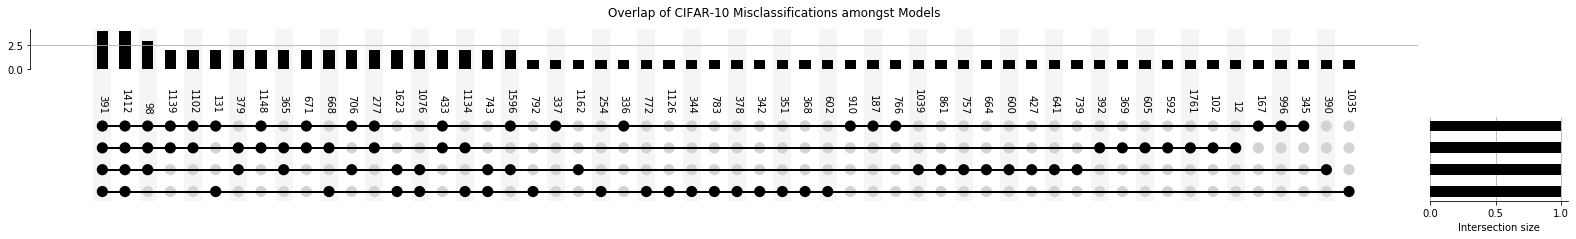

In [324]:
overlap = df101.groupby(list(cols))['index'].count()

plot(overlap, orientation='vertical')  
from matplotlib import pyplot
plt.suptitle('Overlap of CIFAR-10 Misclassifications amongst Models')
pyplot.show() 